initial imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from itertools import groupby
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp

define fields

In [2]:
_PART       = 'RECORDING_SESSION_LABEL'
PART        = 'Participant'
_TRIAL      = 'TRIAL_INDEX'
TRIAL       = 'Trial'
_TARGET     = 'AVERAGE_IA_1_SAMPLE_COUNT_%'
TARGET      = 'Target'
_FILL1      = 'AVERAGE_IA_3_SAMPLE_COUNT_%'
FILL1       = 'Filler1'
_COMP       = 'AVERAGE_IA_2_SAMPLE_COUNT_%'
COMP        = 'Competitor'
_FILL2      = 'AVERAGE_IA_4_SAMPLE_COUNT_%'
FILL2       = 'Filler2'
_TIME       = 'BIN_START_TIME'
TIME        = 'Time'
TYPE        = 'type'
VERSION     = 'version'
TARGET_WORD = 'target_word'


define calculated fields

In [3]:
# calculated special
FILLAvg    = 'Filler Average'
NTAvg      = 'Non Target Average'
TCAvg      = 'Target Competitor Average'
TmC        = 'Target minus Competitor'
TmF        = 'Target minus Filler'
TmNT       = 'Target minus Non Target'
TCmF       = 'Target Competitor minus Filler'

define columns to keep when clearing up some elements

In [4]:
KEEP_COLUMNS = [TIME, PART, TRIAL, TYPE, VERSION, TARGET, COMP, FILL1, FILL2, TARGET_WORD,
                FILLAvg, NTAvg, TCAvg, TmC, TmF, TmNT, TCmF]

define some colors and names for plotting

In [5]:

TARGET_COLOR  = 'red'
COMP_COLOR    = 'blue'
NTargetCOLOR  = 'green'
color_dict={COMP: COMP_COLOR, TARGET: TARGET_COLOR, NTAvg: NTargetCOLOR, FILLAvg: NTargetCOLOR, TCAvg: TARGET_COLOR}


set files names

In [6]:
F_OLD_DATA = 'data/240621_old_time_course_binning.xls.csv'
F_OLD_TOUCH_DATA ='data/240621_old_message_report.xls.csv'
F_YOUNG_DATA = 'data/240621_young_time_course_binning.xls.csv'
F_YOUNG_TOUCH_DATA ='data/240621_young_message_report.xls.csv'

load files

In [7]:
#old_data = pd.read_csv('data/240621_old_time_course_binning.xls.csv')
#old_touch_data = pd.read_csv('data/240621_old_message_report.xls.csv')
#young_data = pd.read_csv('data/240621_young_time_course_binning.xls.csv')
#young_touch_data = pd.read_csv('data/240621_young_message_report.xls.csv')

old_data = pd.read_csv(F_OLD_DATA)
old_touch_data = pd.read_csv(F_OLD_TOUCH_DATA)
young_data = pd.read_csv(F_YOUNG_DATA)
young_touch_data = pd.read_csv(F_YOUNG_TOUCH_DATA)


just dumps the columns and sync columns to keep

In [8]:
LOAD='load'
DIGITS='DigitsCorrect'
RESPONSE='Response'

# KEEP_COLUMNS2 = [TIME, PART, TRIAL, TYPE, LOAD, DIGITS, TARGET, COMP, FILL1, FILL2, 'Response']
old_touch_data.columns, old_data.columns

(Index(['RECORDING_SESSION_LABEL', 'TRIAL_INDEX', 'type', 'DigitsCorrect',
        'load', 'CURRENT_MSG_BLINK_DURATION', 'CURRENT_MSG_BLINK_END',
        'CURRENT_MSG_BLINK_INDEX', 'CURRENT_MSG_BLINK_START',
        'CURRENT_MSG_FIX_DURATION', 'CURRENT_MSG_FIX_END',
        'CURRENT_MSG_FIX_INDEX', 'CURRENT_MSG_FIX_START', 'CURRENT_MSG_FIX_X',
        'CURRENT_MSG_FIX_Y', 'CURRENT_MSG_INDEX', 'CURRENT_MSG_INTEREST_AREAS',
        'CURRENT_MSG_INTEREST_AREA_ID', 'CURRENT_MSG_INTEREST_AREA_INDEX',
        'CURRENT_MSG_INTEREST_AREA_LABEL', 'CURRENT_MSG_IS_RT_END',
        'CURRENT_MSG_IS_RT_START', 'CURRENT_MSG_LABEL',
        'CURRENT_MSG_SAC_AMPLITUDE', 'CURRENT_MSG_SAC_AVG_VELOCITY',
        'CURRENT_MSG_SAC_DURATION', 'CURRENT_MSG_SAC_END_TIME',
        'CURRENT_MSG_SAC_END_X', 'CURRENT_MSG_SAC_END_Y',
        'CURRENT_MSG_SAC_INDEX', 'CURRENT_MSG_SAC_PEAK_VELOCITY',
        'CURRENT_MSG_SAC_START_TIME', 'CURRENT_MSG_SAC_START_X',
        'CURRENT_MSG_SAC_START_Y', 'CURRENT_MSG_TEXT'

In [9]:
#young_touch_data.loc[young_touch_data.CURRENT_MSG_TEXT.str.contains("TRIALID ")]
#young_touch_data.loc[(young_touch_data.TRIAL_INDEX == 5)]

rename columns names

In [10]:
for data in [old_data, old_touch_data, young_data, young_touch_data]:
    data.rename(columns={
        _PART:   PART,
        _TRIAL:  TRIAL,
        _TARGET: TARGET,
        _COMP:   COMP,
        _FILL1:  FILL1,
        _FILL2:  FILL2,
        _TIME:   TIME
    }, inplace=True)

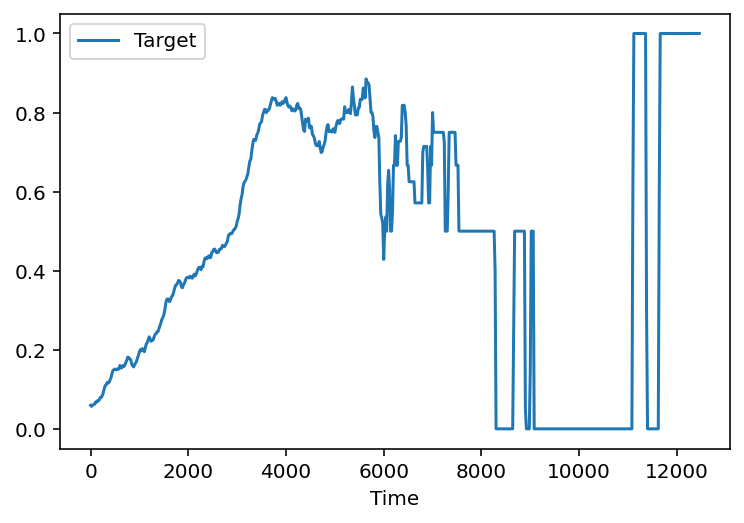

In [12]:
# test plot
old_data[old_data[TYPE] == 'b'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
pp.show()

fix the trial column to be the numbers from 'TRIAL_LABEL' column data 

In [13]:
old_data_1 = old_data.assign(**{TRIAL: lambda x: pd.to_numeric(x['TRIAL_LABEL'].str.strip('Trial: '))})
young_data_1 = young_data.assign(**{TRIAL: lambda x: pd.to_numeric(x['TRIAL_LABEL'].str.strip('Trial: '))})

#### get message report offset

 
 read the message report and extract TOUCH_TARGET time stamp and stimuli timestamp,
 
 calculate ofset for TOUCH_TARGET from mimimum of stimuli (when multiple stimuli exists)

In [14]:
od1 = old_touch_data
yd1 = young_touch_data
# od1['CURRENT_MSG_TEXT']
# TOUCH_TARGET ==> Selection_Target
# Stiimuli ==> Sound_Start
    # filter messages which are not TOUCH_TARGET nor stimuli ...
od2 = od1.loc[(od1['CURRENT_MSG_TEXT'] == 'Selection_Target') |
              (od1['CURRENT_MSG_TEXT'].str.contains('Sound_Start'))]

yd2 = yd1.loc[(yd1['CURRENT_MSG_TEXT'] == 'Selection_Target') |
              (yd1['CURRENT_MSG_TEXT'].str.contains('Sound_Start'))]


#od2

#od2[od2['CURRENT_MSG_TEXT'].str.contains('Sound_Start')].pivot_table(
#    index=[PART, TRIAL], values='CURRENT_MSG_TIME', aggfunc=min
#)

#od2


In [15]:
# show columns
od2.columns

Index(['Participant', 'Trial', 'type', 'DigitsCorrect', 'load',
       'CURRENT_MSG_BLINK_DURATION', 'CURRENT_MSG_BLINK_END',
       'CURRENT_MSG_BLINK_INDEX', 'CURRENT_MSG_BLINK_START',
       'CURRENT_MSG_FIX_DURATION', 'CURRENT_MSG_FIX_END',
       'CURRENT_MSG_FIX_INDEX', 'CURRENT_MSG_FIX_START', 'CURRENT_MSG_FIX_X',
       'CURRENT_MSG_FIX_Y', 'CURRENT_MSG_INDEX', 'CURRENT_MSG_INTEREST_AREAS',
       'CURRENT_MSG_INTEREST_AREA_ID', 'CURRENT_MSG_INTEREST_AREA_INDEX',
       'CURRENT_MSG_INTEREST_AREA_LABEL', 'CURRENT_MSG_IS_RT_END',
       'CURRENT_MSG_IS_RT_START', 'CURRENT_MSG_LABEL',
       'CURRENT_MSG_SAC_AMPLITUDE', 'CURRENT_MSG_SAC_AVG_VELOCITY',
       'CURRENT_MSG_SAC_DURATION', 'CURRENT_MSG_SAC_END_TIME',
       'CURRENT_MSG_SAC_END_X', 'CURRENT_MSG_SAC_END_Y',
       'CURRENT_MSG_SAC_INDEX', 'CURRENT_MSG_SAC_PEAK_VELOCITY',
       'CURRENT_MSG_SAC_START_TIME', 'CURRENT_MSG_SAC_START_X',
       'CURRENT_MSG_SAC_START_Y', 'CURRENT_MSG_TEXT', 'CURRENT_MSG_TIME',
       'CUR

find which trials are missing entries of stimuli touch report bundle

In [16]:

od3 = od2.pivot_table(index=[PART], values=[
     'CURRENT_MSG_TEXT'], columns=[TRIAL], aggfunc=[len])

yd3 = yd2.pivot_table(index=[PART], values=[
     'CURRENT_MSG_TEXT'], columns=[TRIAL], aggfunc=[len])


In [18]:
#od3, yd3

In [19]:

    # pivot table to have columns for TOUCH_TARGET and Stimuli, have min value of CURRENT_MSG_TIME as the new value
od5 = od2.pivot_table(index=[PART, TRIAL],
                            columns=['CURRENT_MSG_TEXT'],
                            values='CURRENT_MSG_TIME', aggfunc=min)

yd5 = yd2.pivot_table(index=[PART, TRIAL],
                            columns=['CURRENT_MSG_TEXT'],
                            values='CURRENT_MSG_TIME', aggfunc=min)


#od5
    # find out missing TOUCH_TARGET trials
#od5[od5['Selection_Target'].isnull()]

In [20]:
    # get the int value instead of float
od5_1 = od5[~od5['Selection_Target'].isnull()].astype(int)

yd5_1 = yd5[~yd5['Selection_Target'].isnull()].astype(int)
#od5_1

In [21]:
   # fill Nan as 0, set type to int and calculate offset from Stimuli to TOUCH_TARGET
od6 = od5.fillna(0).astype(int).assign(
        TOUCH_FIXED=lambda x: x['Selection_Target'] - x['Sound_Start'])

yd6 = yd5.fillna(0).astype(int).assign(
        TOUCH_FIXED=lambda x: x['Selection_Target'] - x['Sound_Start'])


#od6


In [22]:
   # missing TOUCH_TARGET message report
od6[od6['TOUCH_FIXED'] < 0]
yd6[yd6['TOUCH_FIXED'] < 0]

CURRENT_MSG_TEXT   Selection_Target  Sound_Start  TOUCH_FIXED
Participant Trial                                            
104         1                     0         8539        -8539
109         13                    0         9886        -9886
            52                    0         7423        -7423
            65                    0         7841        -7841
110         10                    0        10388       -10388
            17                    0        10146       -10146
            41                    0        10091       -10091
            70                    0         8658        -8658
            75                    0         8840        -8840
113         18                    0        10549       -10549
118         17                    0        10762       -10762
            35                    0        10562       -10562
            59                    0         7084        -7084
125         7                     0         9584        -9584
127         9                     0         6391        -6391
128         1                     0        38956       -38956
133         29                    0        14916       -14916
135         16                    0         8253        -8253

In [23]:
    # rename only the indexs 
od7 = od6.rename_axis([PART, TRIAL])
yd7 = yd6.rename_axis([PART, TRIAL])
od7
yd7

CURRENT_MSG_TEXT   Selection_Target  Sound_Start  TOUCH_FIXED
Participant Trial                                            
101         1                115816       111088         4728
            2                 14438        11863         2575
            3                 13471        11763         1708
            4                 14967        11267         3700
            5                 14861        11062         3799
...                             ...          ...          ...
135         79                13804         9965         3839
            80                13224        10621         2603
            81                14225        10315         3910
            82                13176         9363         3813
            83                13098        10097         3001

[2546 rows x 3 columns]

get message report offset - finished

In [24]:

old_touch_data_1 = od6
young_touch_data_1 = yd6

merge the data with touch data

In [25]:
old_data_with_touch = pd.merge(old_data_1.set_index([PART, TRIAL]),
                               old_touch_data_1,
                               on=[PART, TRIAL])

young_data_with_touch = pd.merge(young_data_1.set_index([PART, TRIAL]),
                               young_touch_data_1,
                               on=[PART, TRIAL])

In [26]:
def plot_part_trial(data2, _p, _t):
#    (_p, _t) = (411, 9)
    p = data2.loc[_p].loc[_t].plot(x=TIME, y=TARGET)
    p2 = p.bar(x=data2.loc[_p].loc[_t].TOUCH_FIXED.values[0],
               height=10, width=20, color="red")
    p3 = p.bar(x=1500, height=10, width=20, color='magenta')
    p4 = p.bar(x=2700, height=10, width=20, color='black')
    p.set_ylim(-10, 100)
    p.set_title("Part: {}, Trial: {}, Type: {}".format(
        _p, _t, data2.loc[_p].loc[_t].index[0]), fontsize=TITLE_FONT_SIZE)
    p.legend(['Target', 'cutoff {}'.format(
        data2.loc[_p].loc[_t].TOUCH_FIXED.values[0]), 'qend: 1500', 'target: 2700'], loc='upper left',
        fontsize=LEGEND_FONT_SIZE)

In [27]:
#old_data_with_touch
#z=old_data_with_touch.set_index(TYPE)

#p = old_data_with_touch.loc[201].loc[5].plot(x=TIME, y=TARGET)

#plot_part_trial(z, 201, 5)

if we want to plot target for specific participant and trial

In [28]:
# not working ATM
#plot_part_trial(old_data_with_touch.set_index(PART, TRIAL, TYPE), 205, 5)

In [29]:
odt1 = old_data_with_touch
ydt1 = young_data_with_touch
odt1
ydt1

TRIAL_LABEL  BIN_INDEX  AVERAGE_BLINK_SAMPLE_COUNT_%  \
Participant Trial                                                        
101         1        Trial: 1          0                           1.0   
            1        Trial: 1          1                           1.0   
            1        Trial: 1          2                           1.0   
            1        Trial: 1          3                           1.0   
            1        Trial: 1          4                           1.0   
...                       ...        ...                           ...   
135         83      Trial: 83        146                           0.0   
            83      Trial: 83        147                           0.0   
            83      Trial: 83        148                           0.0   
            83      Trial: 83        149                           0.0   
            83      Trial: 83        150                           0.0   

                   AVERAGE_EXCLUDED_SAMPLE_COUNT_%  Target  Competitor  \
Participant Trial                                                        
101         1                                  0.0     0.0         0.0   
            1                                  0.0     0.0         0.0   
            1                                  0.0     0.0         0.0   
            1                                  0.0     0.0         0.0   
            1                                  0.0     0.0         0.0   
...                                            ...     ...         ...   
135         83                                 0.0     1.0         0.0   
            83                                 0.0     1.0         0.0   
            83                                 0.0     1.0         0.0   
            83                                 0.0     1.0         0.0   
            83                                 0.0     1.0         0.0   

                   Filler1  Filler2  AVERAGE_IA_0_SAMPLE_COUNT_%  \
Participant Trial                                                  
101         1          0.0      0.0                          0.0   
            1          0.0      0.0                          0.0   
            1          0.0      0.0                          0.0   
            1          0.0      0.0                          0.0   
            1          0.0      0.0                          0.0   
...                    ...      ...                          ...   
135         83         0.0      0.0                          0.0   
            83         0.0      0.0                          0.0   
            83         0.0      0.0                          0.0   
            83         0.0      0.0                          0.0   
            83         0.0      0.0                          0.0   

                   BIN_DURATION  ...  load  version competitor    filler1  \
Participant Trial                ...                                        
101         1                20  ...     4       AH   ayin.jpg   bama.jpg   
            1                20  ...     4       AH   ayin.jpg   bama.jpg   
            1                20  ...     4       AH   ayin.jpg   bama.jpg   
            1                20  ...     4       AH   ayin.jpg   bama.jpg   
            1                20  ...     4       AH   ayin.jpg   bama.jpg   
...                         ...  ...   ...      ...        ...        ...   
135         83               20  ...     4       AL  kufsa.jpg  maxak.jpg   
            83               20  ...     4       AL  kufsa.jpg  maxak.jpg   
            83               20  ...     4       AL  kufsa.jpg  maxak.jpg   
            83               20  ...     4       AL  kufsa.jpg  maxak.jpg   
            83               20  ...     4       AL  kufsa.jpg  maxak.jpg   

                      filler2         target type Selection_Target  \
Participant Trial                                                    
101         1       kelev.jpg  televizia.jpg    p           11581

plot for reference before padding and chopping

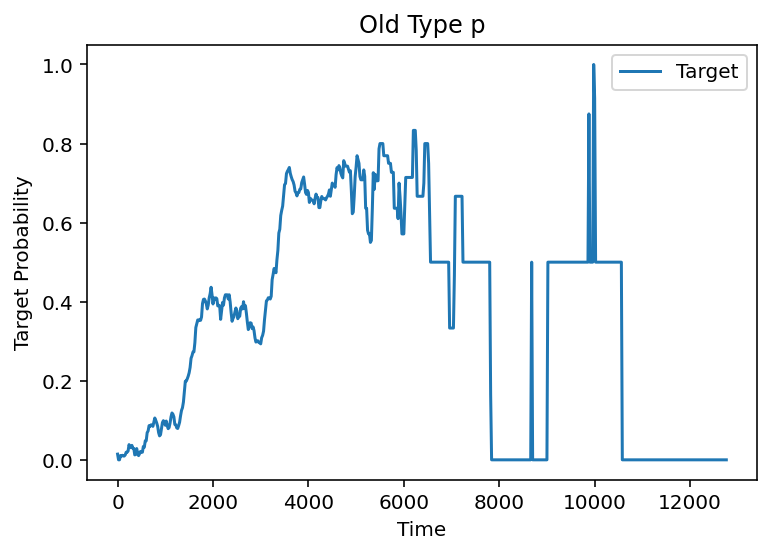

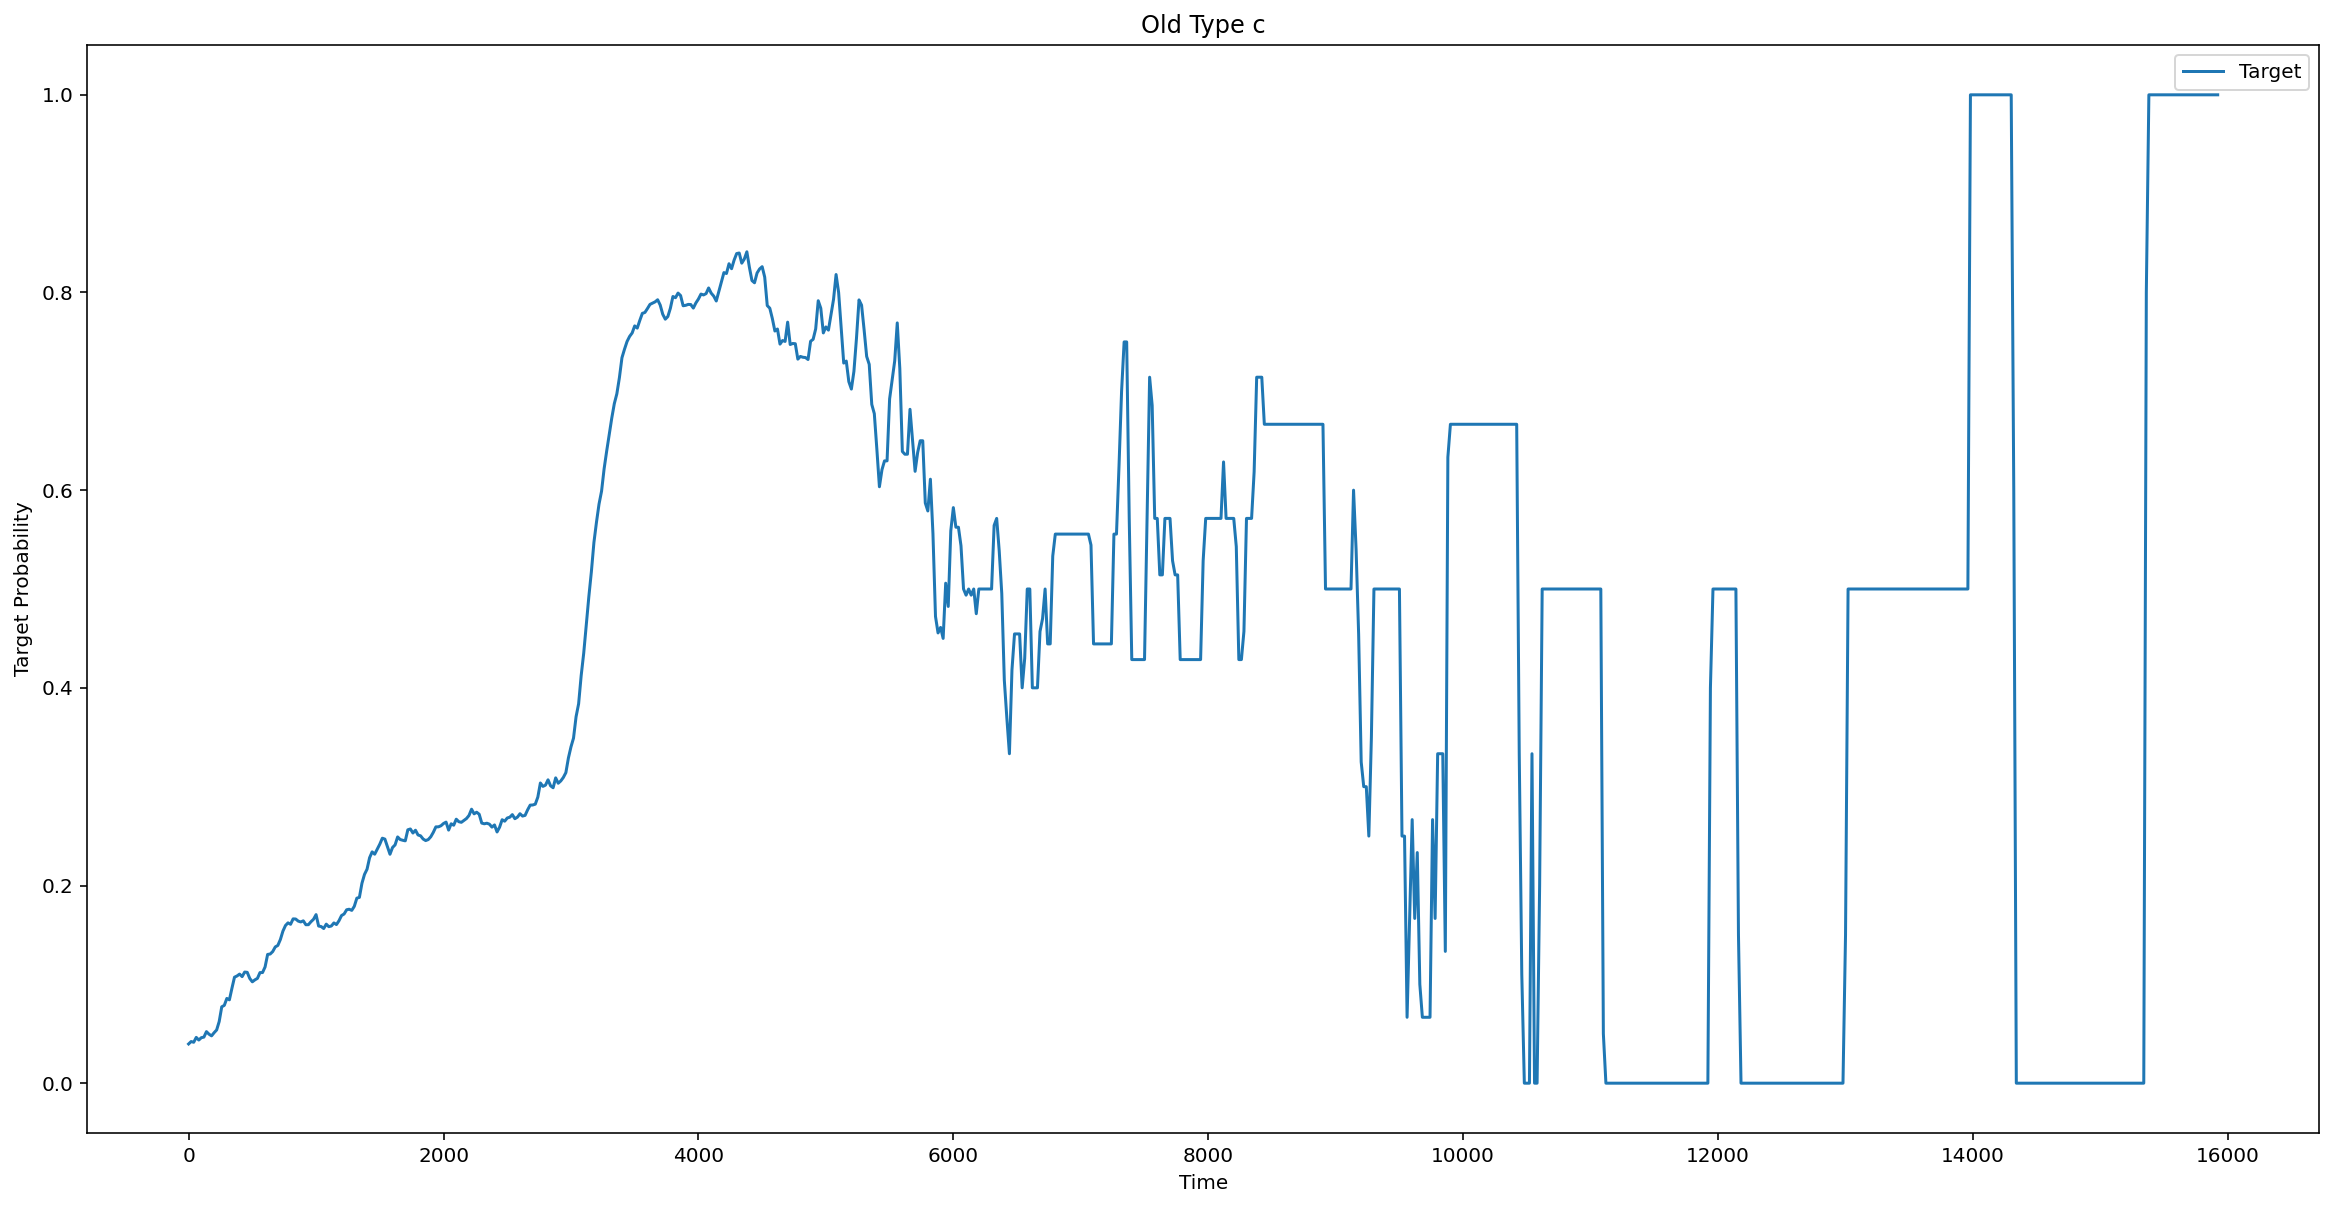

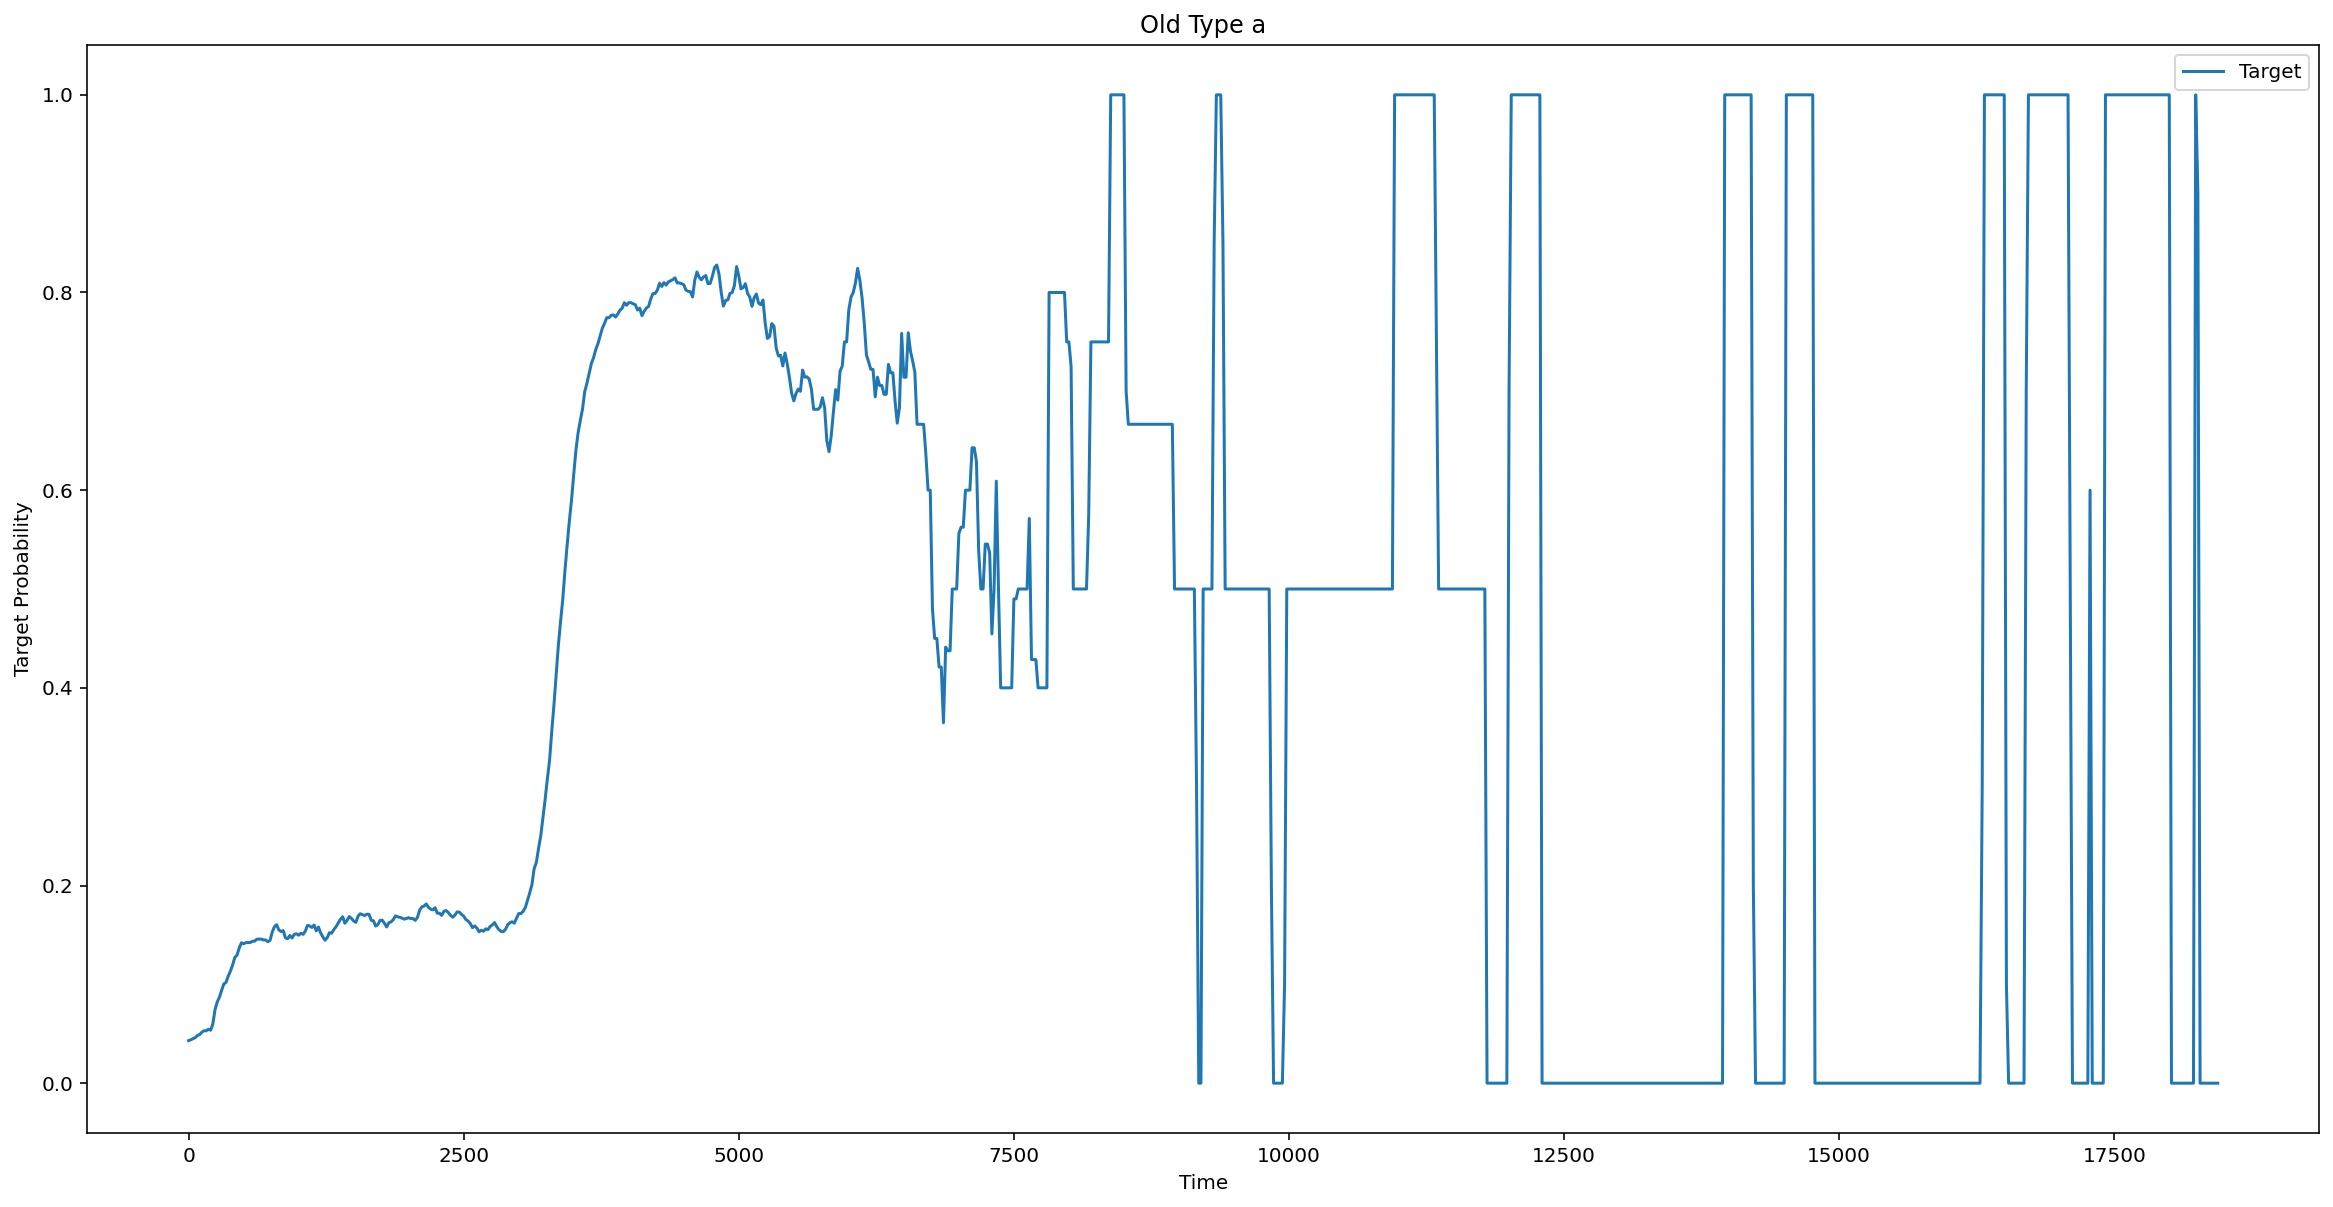

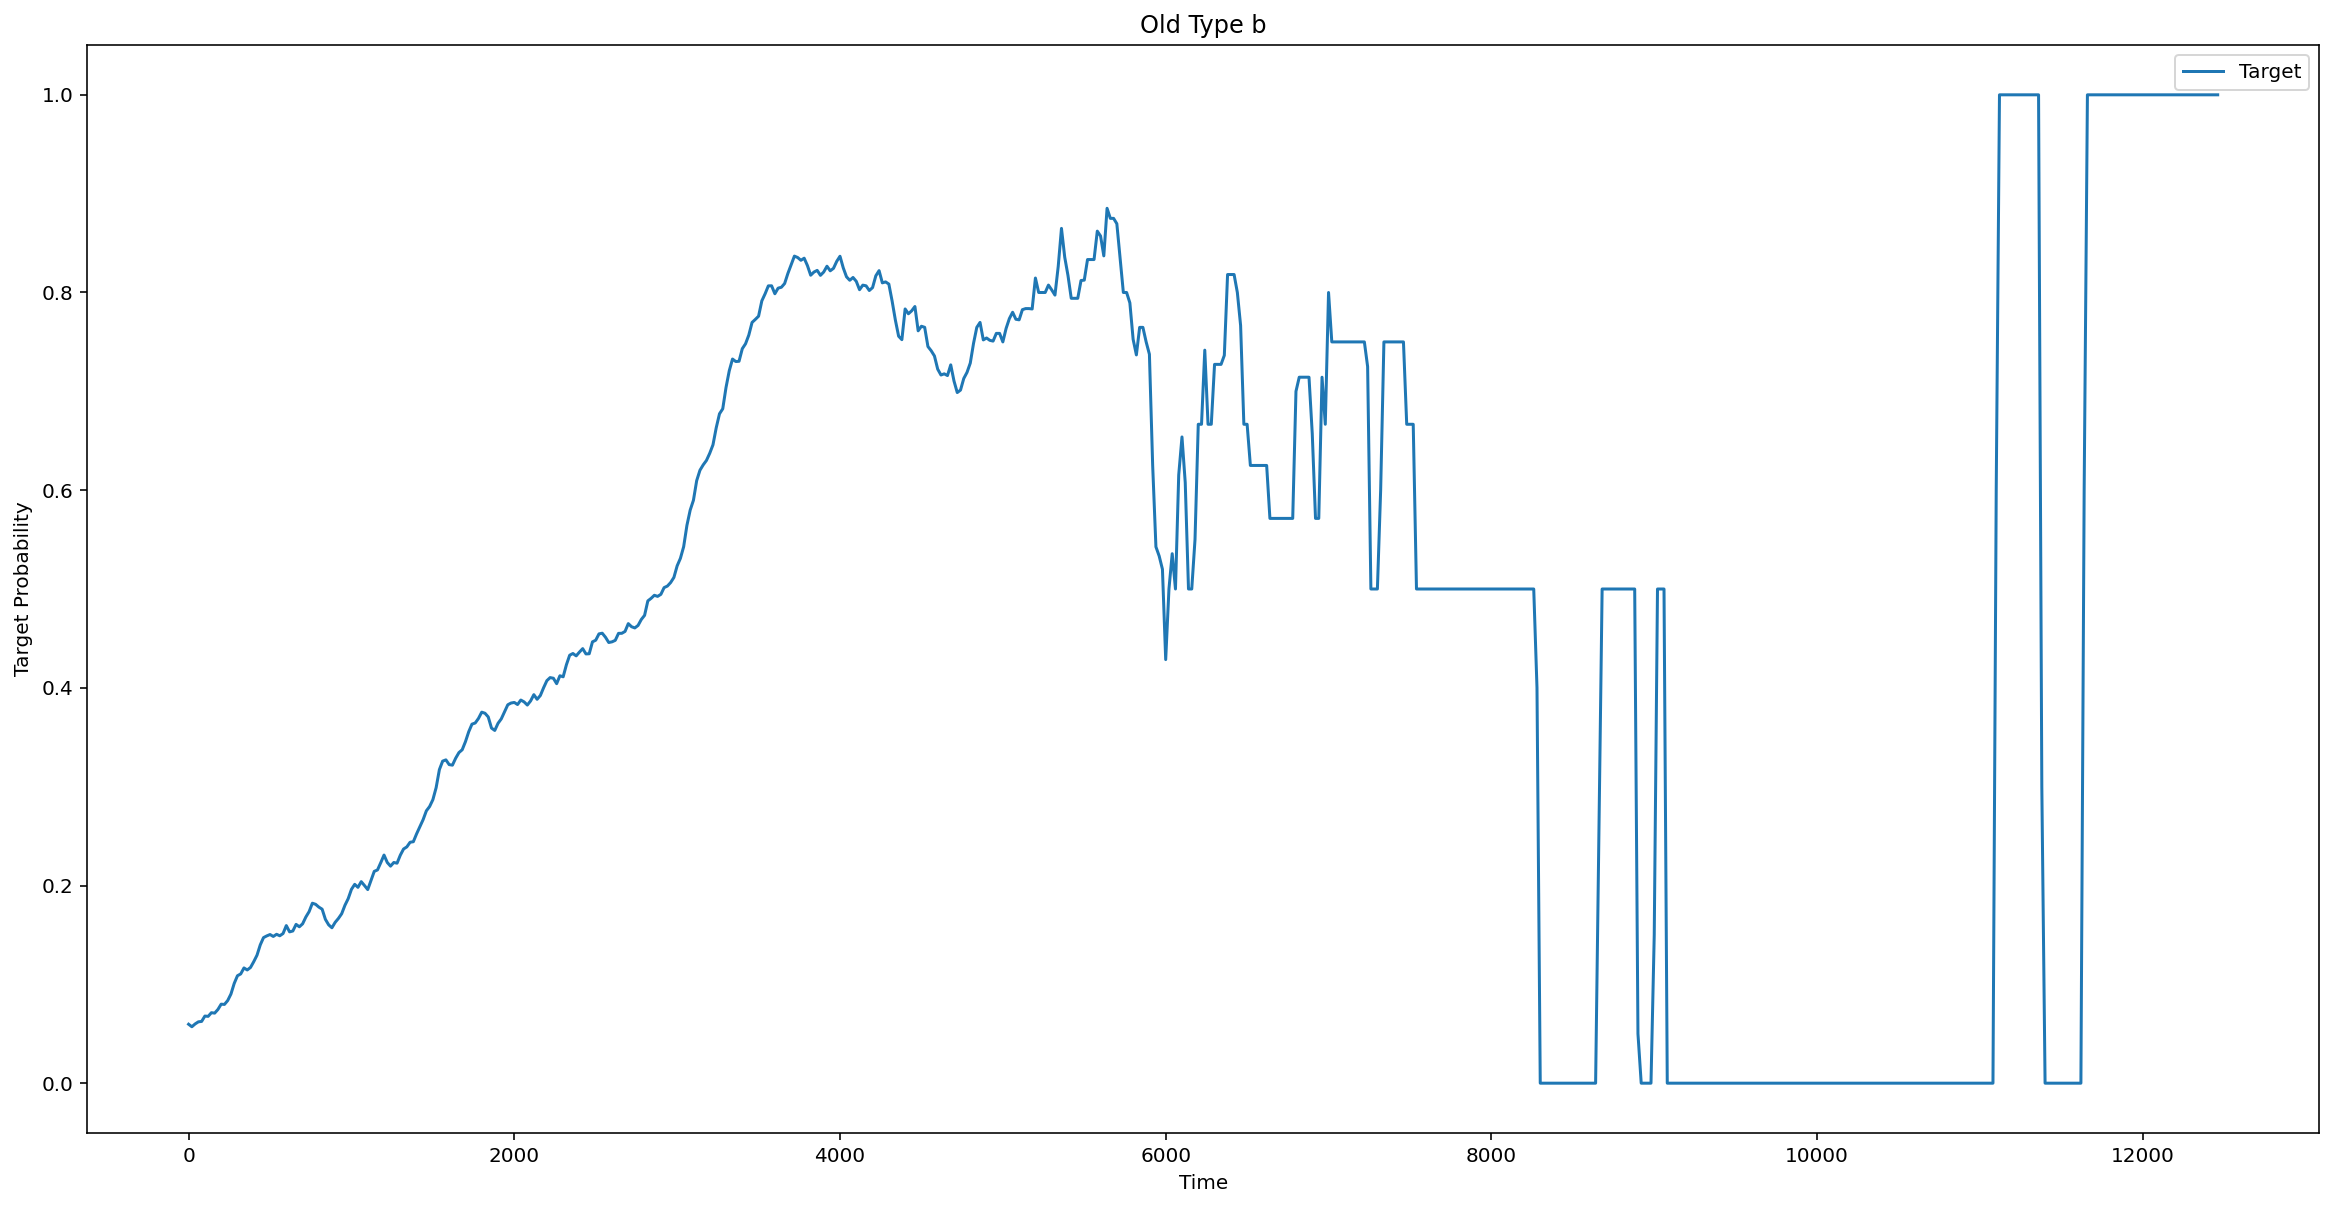

In [30]:
# old data
#odt1[odt1[TYPE] == 'a'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
#odt1[odt1[TYPE] == 'b'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
#odt1[odt1[TYPE] == 'c'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
#odt1[odt1[TYPE] == 'p'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()

for t in odt1[TYPE].unique():
    odt1[odt1[TYPE] == t].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
    pp.title('Old Type ' + t)
    pp.ylabel('Target Probability')
    pp.xlabel('Time')
    pp.rcParams['figure.figsize'] = (20.0, 10.0)
    pp.show()


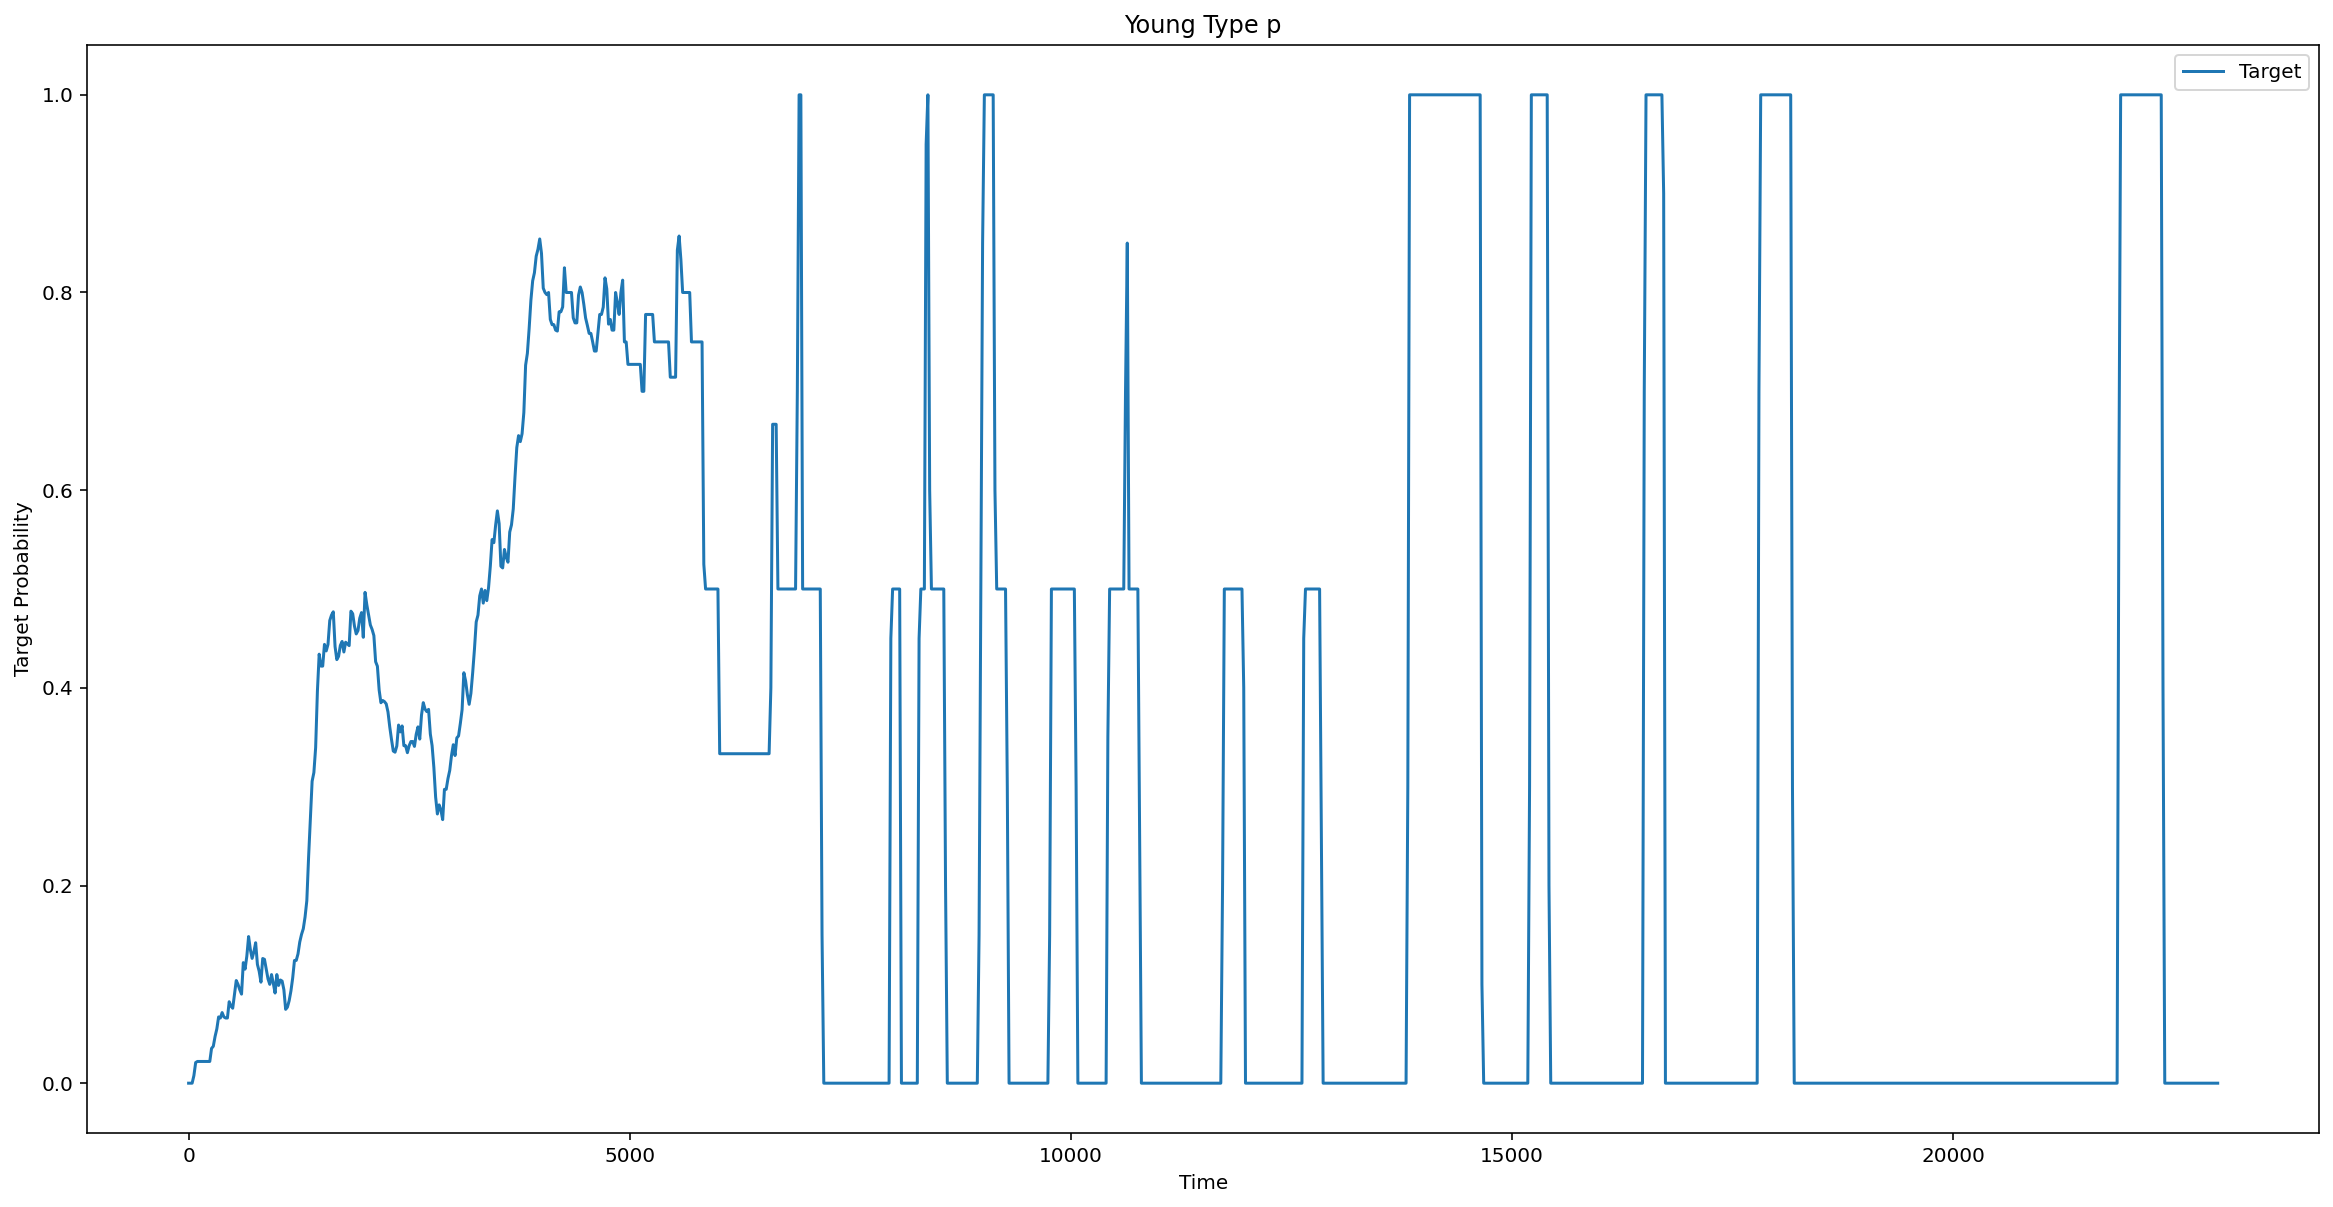

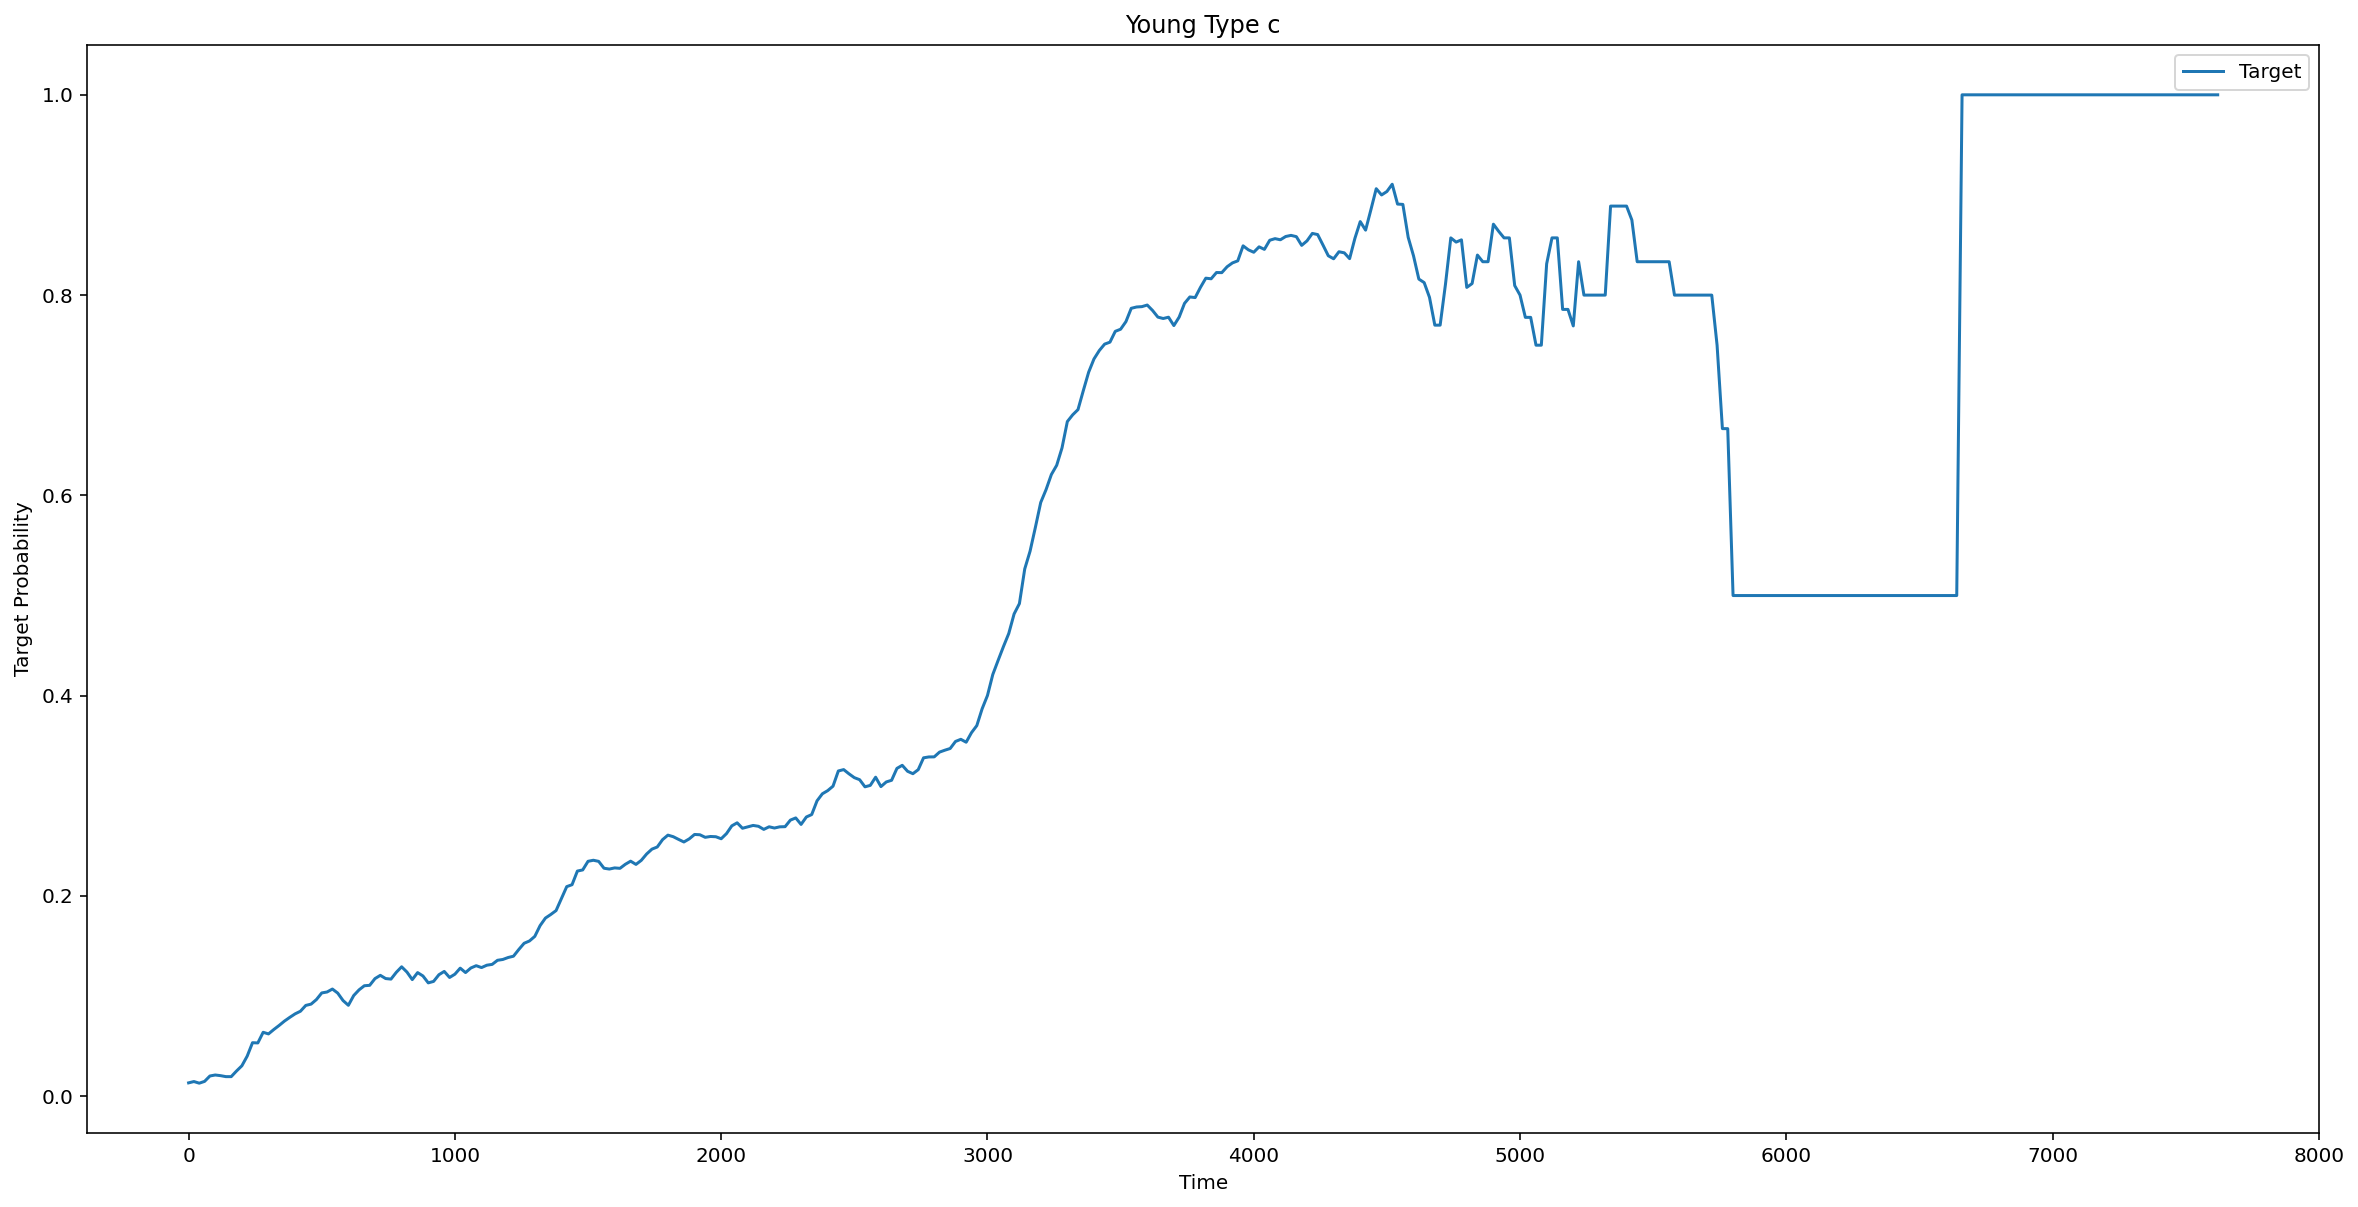

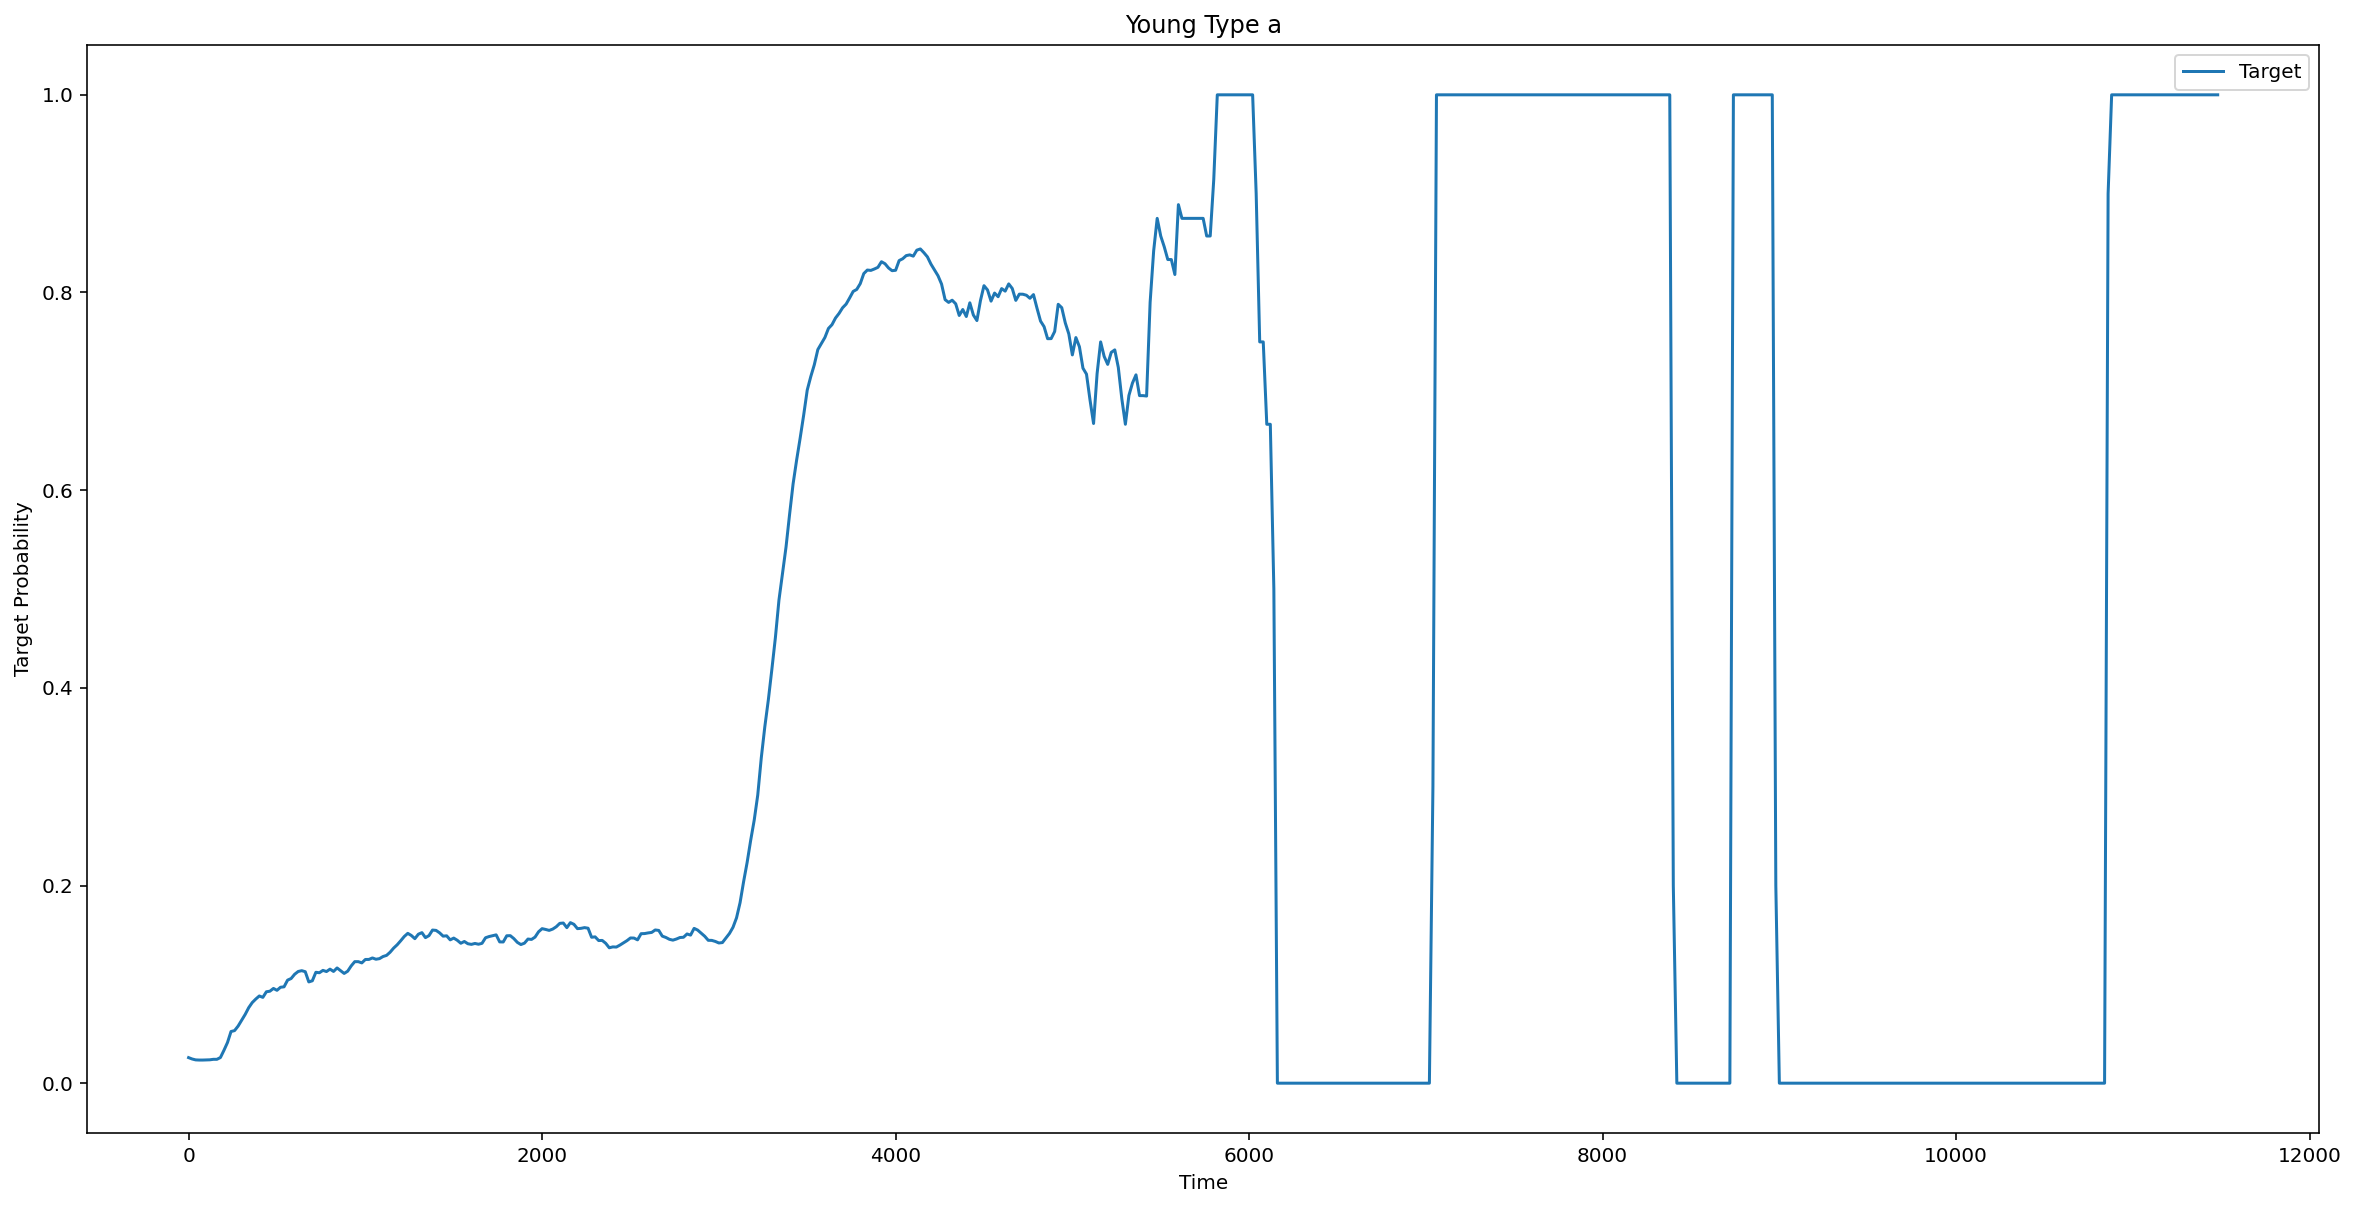

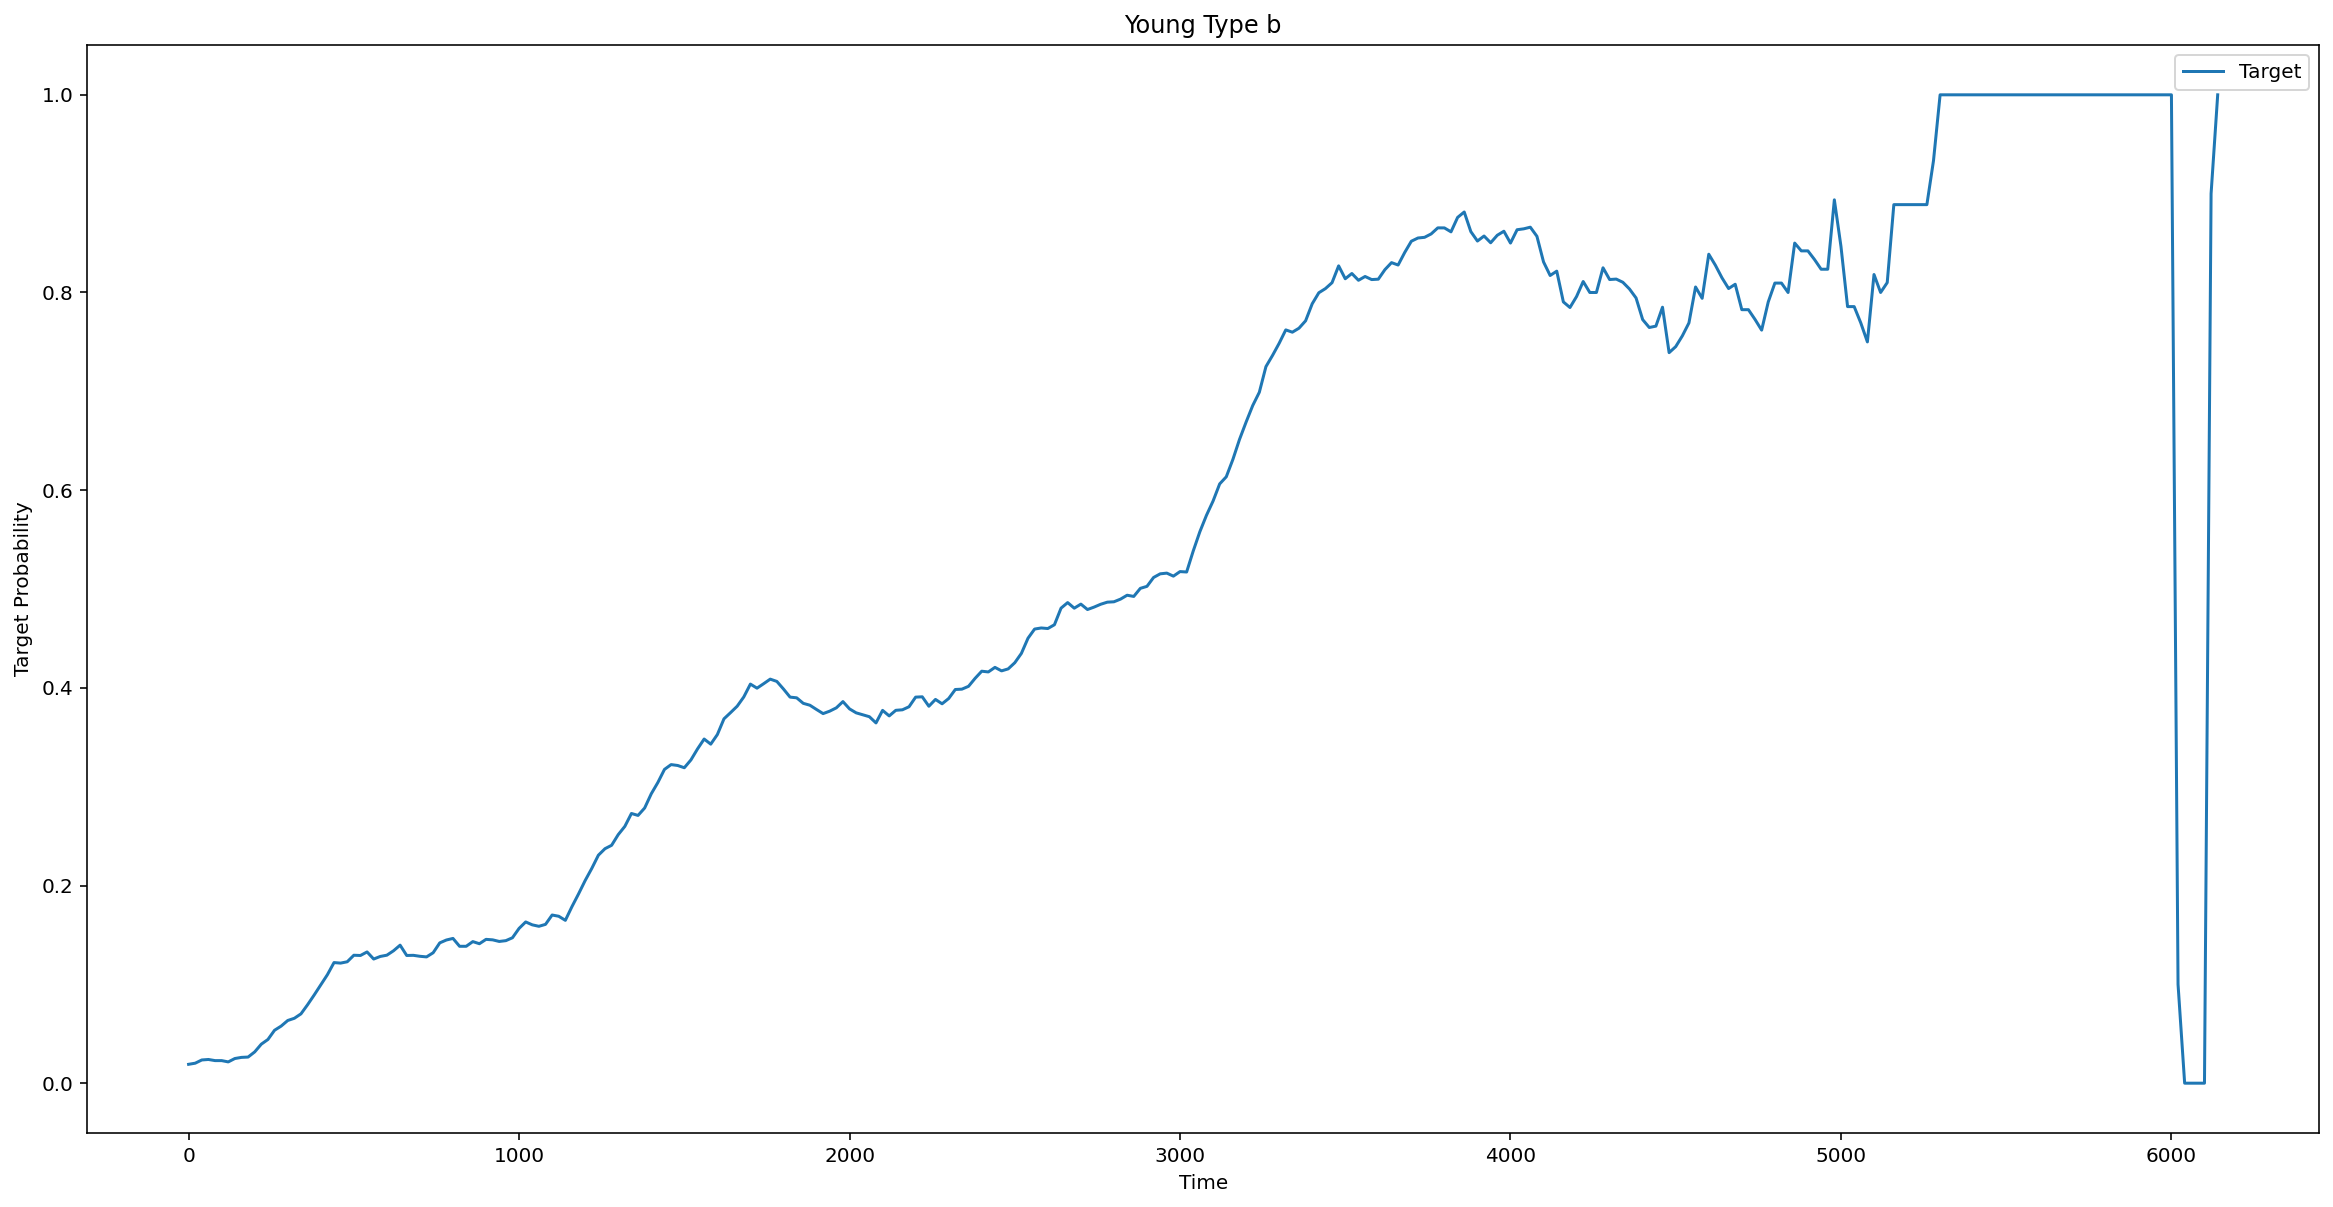

In [31]:
# young data
#ydt1[ydt1[TYPE] == 'a'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
#ydt1[ydt1[TYPE] == 'b'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
#ydt1[ydt1[TYPE] == 'c'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
#ydt1[ydt1[TYPE] == 'p'].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()

for t in ydt1[TYPE].unique():
    ydt1[ydt1[TYPE] == t].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
    pp.title('Young Type ' + t)
    pp.ylabel('Target Probability')
    pp.xlabel('Time')
    pp.rcParams['figure.figsize'] = (20.0, 10.0)
    pp.show()

convert to pivot table to populate missing data cells

**NOTE**: this is a long process

In [38]:
%%time
KEEP_COLUMNS2 = [LOAD, DIGITS, TARGET, COMP, FILL1, FILL2, RESPONSE, 'TOUCH_FIXED']

#odt121 = odt1[odt1[TIME] <= 5000]
#odt121 = odt121[odt121[TYPE] != 'p']
odt121 = odt1
ydt121 = ydt1


#ref : https://stackoverflow.com/questions/54527175/pandas-in-pivot-table-how-to-custom-fill-missing-values#54527289
odt122 = odt121.pivot_table(index=[PART, TRIAL, TYPE],
                            #values=['TOUCH_FIXED', TARGET, COMP, FILL1, FILL2],
                            values=[LOAD, DIGITS, TARGET, COMP, FILL1, FILL2, RESPONSE, 'TOUCH_FIXED'],
                            columns=[TIME],
                            aggfunc=lambda x:x,
                            fill_value=None).fillna(method='ffill', axis=1)


ydt122 = ydt121.pivot_table(index=[PART, TRIAL, TYPE],
                            #values=['TOUCH_FIXED', TARGET, COMP, FILL1, FILL2],
                            values=[LOAD, DIGITS, TARGET, COMP, FILL1, FILL2, RESPONSE, 'TOUCH_FIXED'],
                            columns=[TIME],
                            aggfunc=lambda x:x,
                            fill_value=None).fillna(method='ffill', axis=1)
odt122, ydt122

CPU times: user 3min 35s, sys: 4.55 s, total: 3min 39s
Wall time: 3min 41s


manipulate some of the data to bring it back to the original form

In [41]:
%%time


# fix back from pivoted data
odt123 = odt122.stack().astype({'TOUCH_FIXED': int, LOAD: int})
odt124 = odt123.reset_index()

ydt123 = ydt122.stack().astype({'TOUCH_FIXED': int, LOAD: int})
ydt124 = ydt123.reset_index()

odt124, ydt124

CPU times: user 4.87 s, sys: 974 ms, total: 5.84 s
Wall time: 5.93 s


(         Participant  Trial type   Time Competitor DigitsCorrect Filler1  \
 0                201      1    p      0        0.0             y     0.0   
 1                201      1    p     20        0.0             y     0.0   
 2                201      1    p     40        0.0             y     0.0   
 3                201      1    p     60        0.0             y     0.0   
 4                201      1    p     80        0.0             y     0.0   
 ...              ...    ...  ...    ...        ...           ...     ...   
 2702539          241     83    b  18360        0.0             y     0.0   
 2702540          241     83    b  18380        0.0             y     0.0   
 2702541          241     83    b  18400        0.0             y     0.0   
 2702542          241     83    b  18420        0.0             y     0.0   
 2702543          241     83    b  18440        0.0             y     0.0   
 
         Filler2 Response  TOUCH_FIXED Target  load  
 0           0.0   T

chop on time threshold and omit practice data

In [43]:
%%time

odt4 = odt124[odt124[TIME] <= 5000] 
odt4 = odt4[odt4[TYPE] != 'p']

ydt4 = ydt124[ydt124[TIME] <= 5000] 
ydt4 = ydt4[ydt4[TYPE] != 'p']

odt4, ydt4

CPU times: user 1.06 s, sys: 458 ms, total: 1.52 s
Wall time: 1.55 s


(         Participant  Trial type  Time Competitor DigitsCorrect Filler1  \
 2769             201      4    c     0        0.0             y     0.0   
 2770             201      4    c    20        0.0             y     0.0   
 2771             201      4    c    40        0.0             y     0.0   
 2772             201      4    c    60        0.0             y     0.0   
 2773             201      4    c    80        0.0             y     0.0   
 ...              ...    ...  ...   ...        ...           ...     ...   
 2701867          241     83    b  4920        0.0             y     0.0   
 2701868          241     83    b  4940        0.0             y     0.0   
 2701869          241     83    b  4960        0.0             y     0.0   
 2701870          241     83    b  4980        0.0             y     0.0   
 2701871          241     83    b  5000        0.0             y     0.0   
 
         Filler2 Response  TOUCH_FIXED Target  load  
 2769        0.0   Target       

cleanup: clean the practice type and clean the extra data generated when applying missing time bins earlier

In [44]:
%%time

#ref: df[df['column name'].map(lambda x: str(x)!=".")]
# from : https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression

ydt41=ydt4[ydt4[TYPE] != 'p']
ydt42=ydt41[ydt41[LOAD].map(lambda x: x != -1)]

odt41=odt4[odt4[TYPE] != 'p']
odt42=odt41[odt41[LOAD].map(lambda x: x != -1)]


odt42,ydt42
odt4=odt42
ydt4=ydt42

CPU times: user 448 ms, sys: 89.3 ms, total: 537 ms
Wall time: 545 ms


plotting the graphs

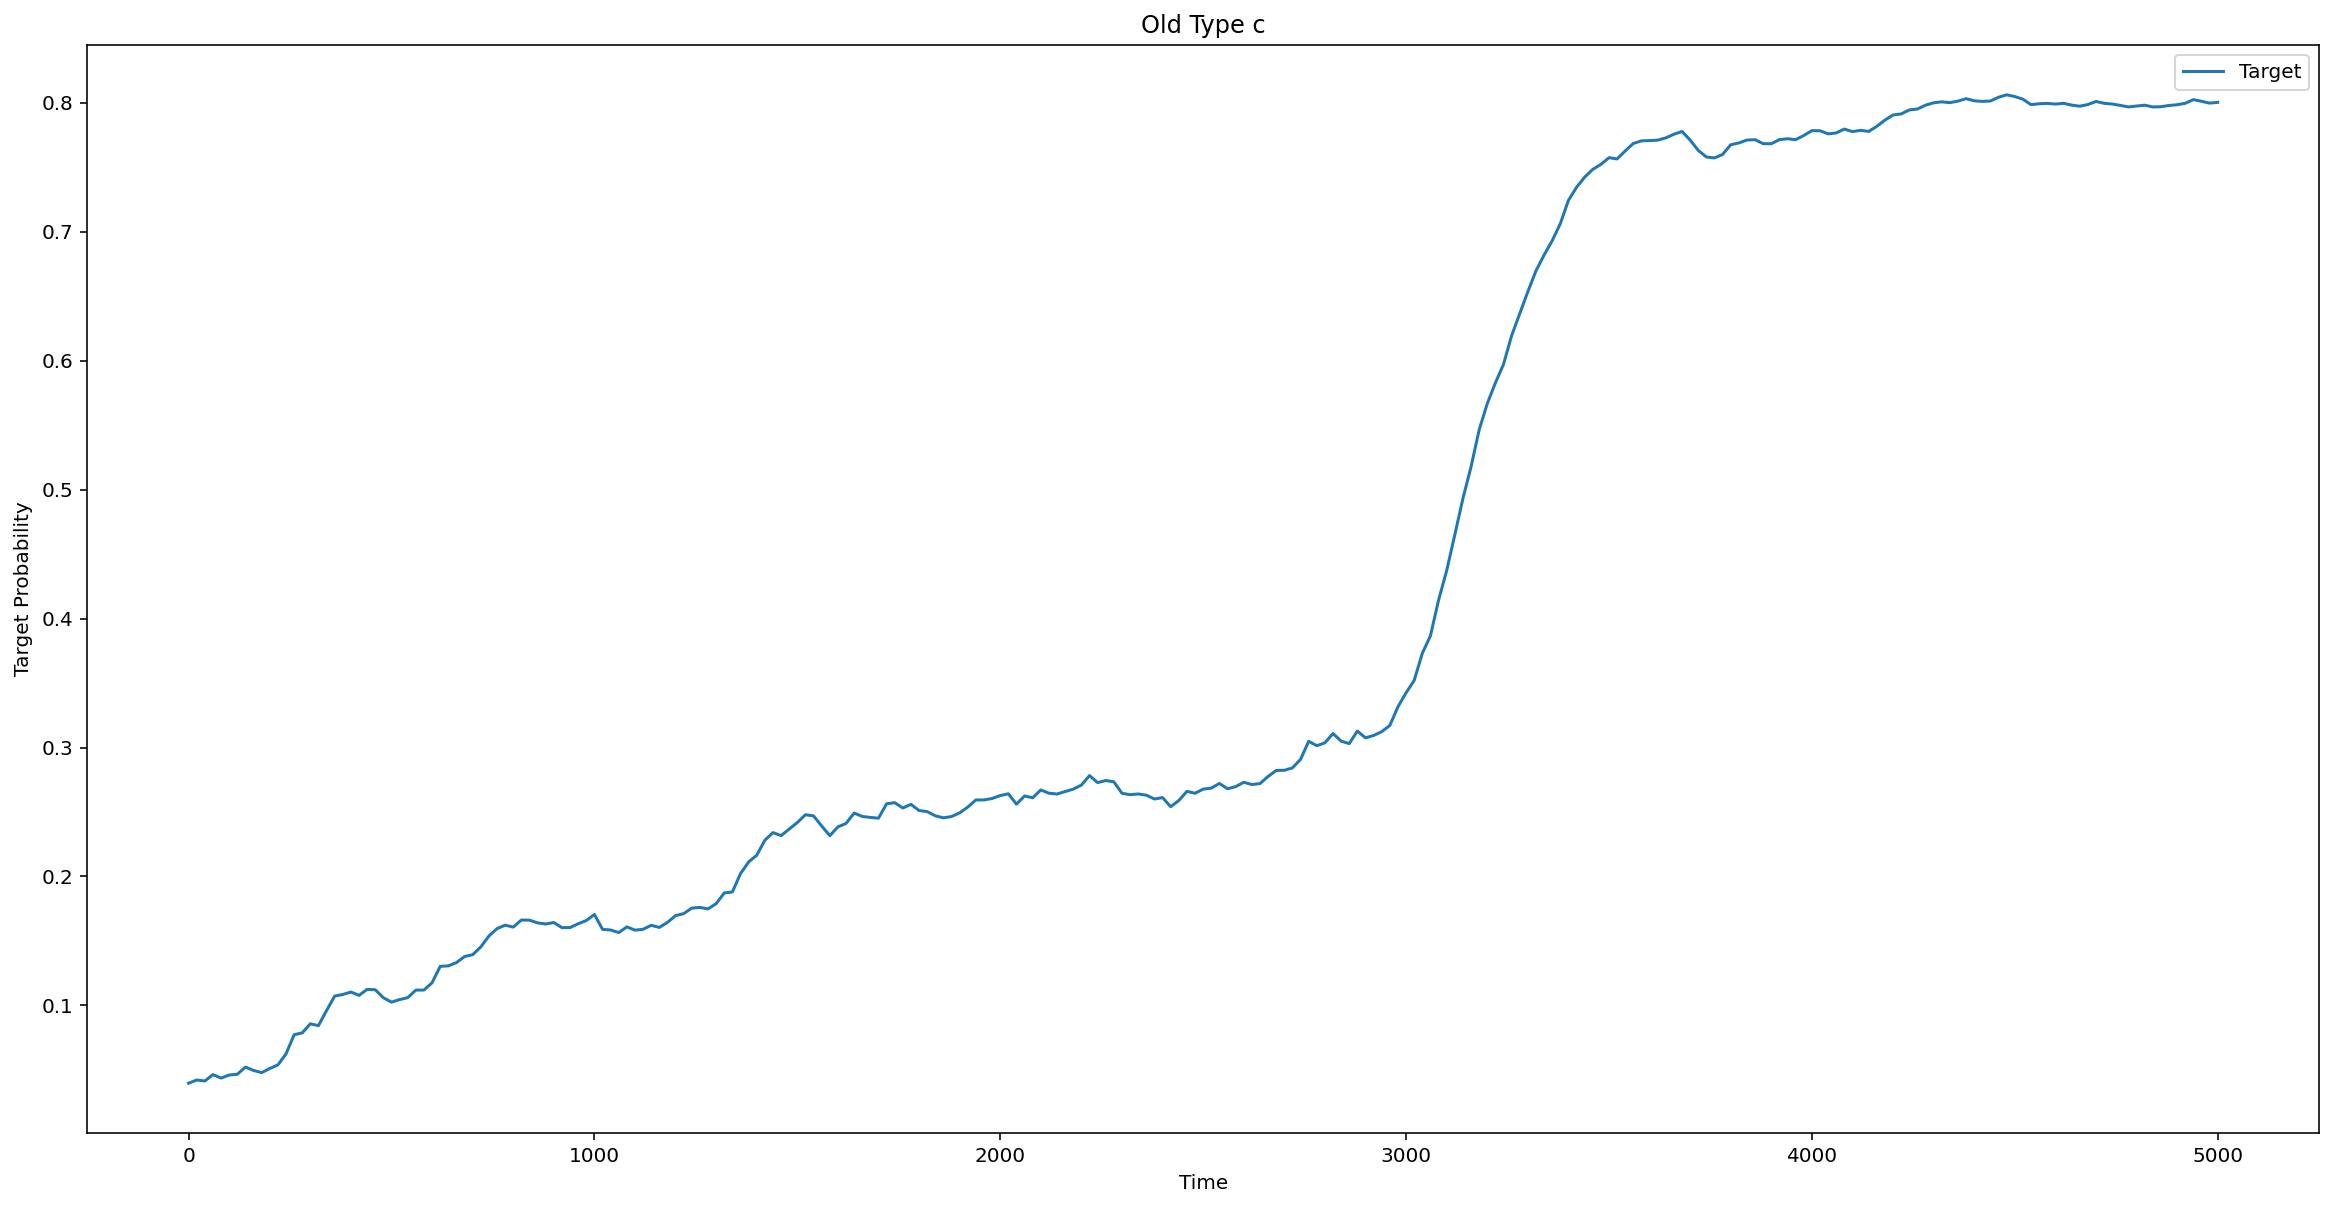

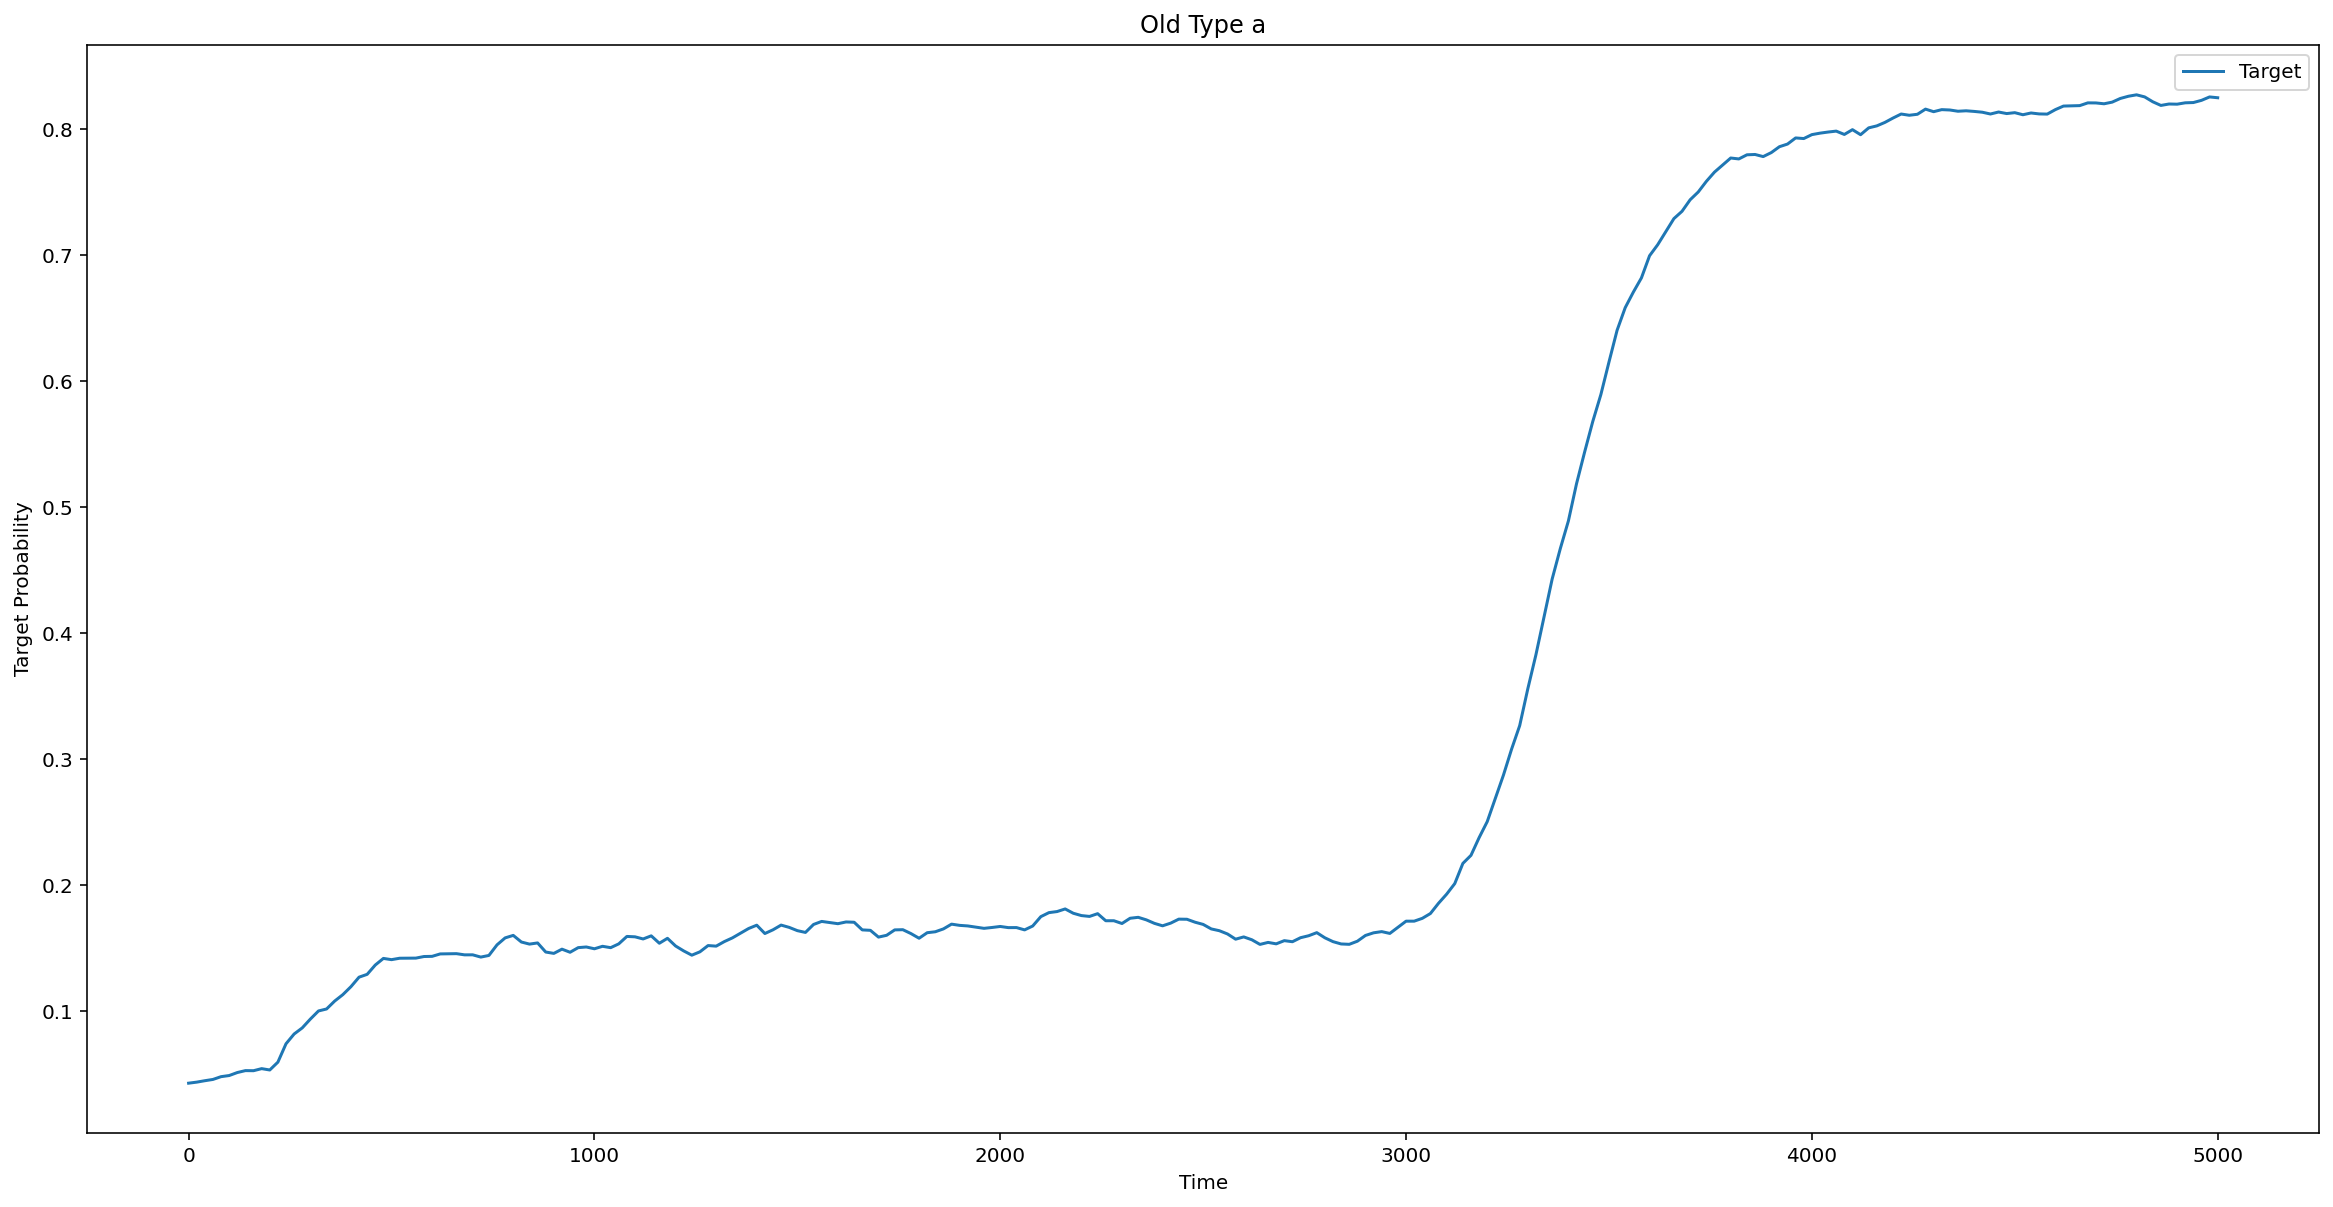

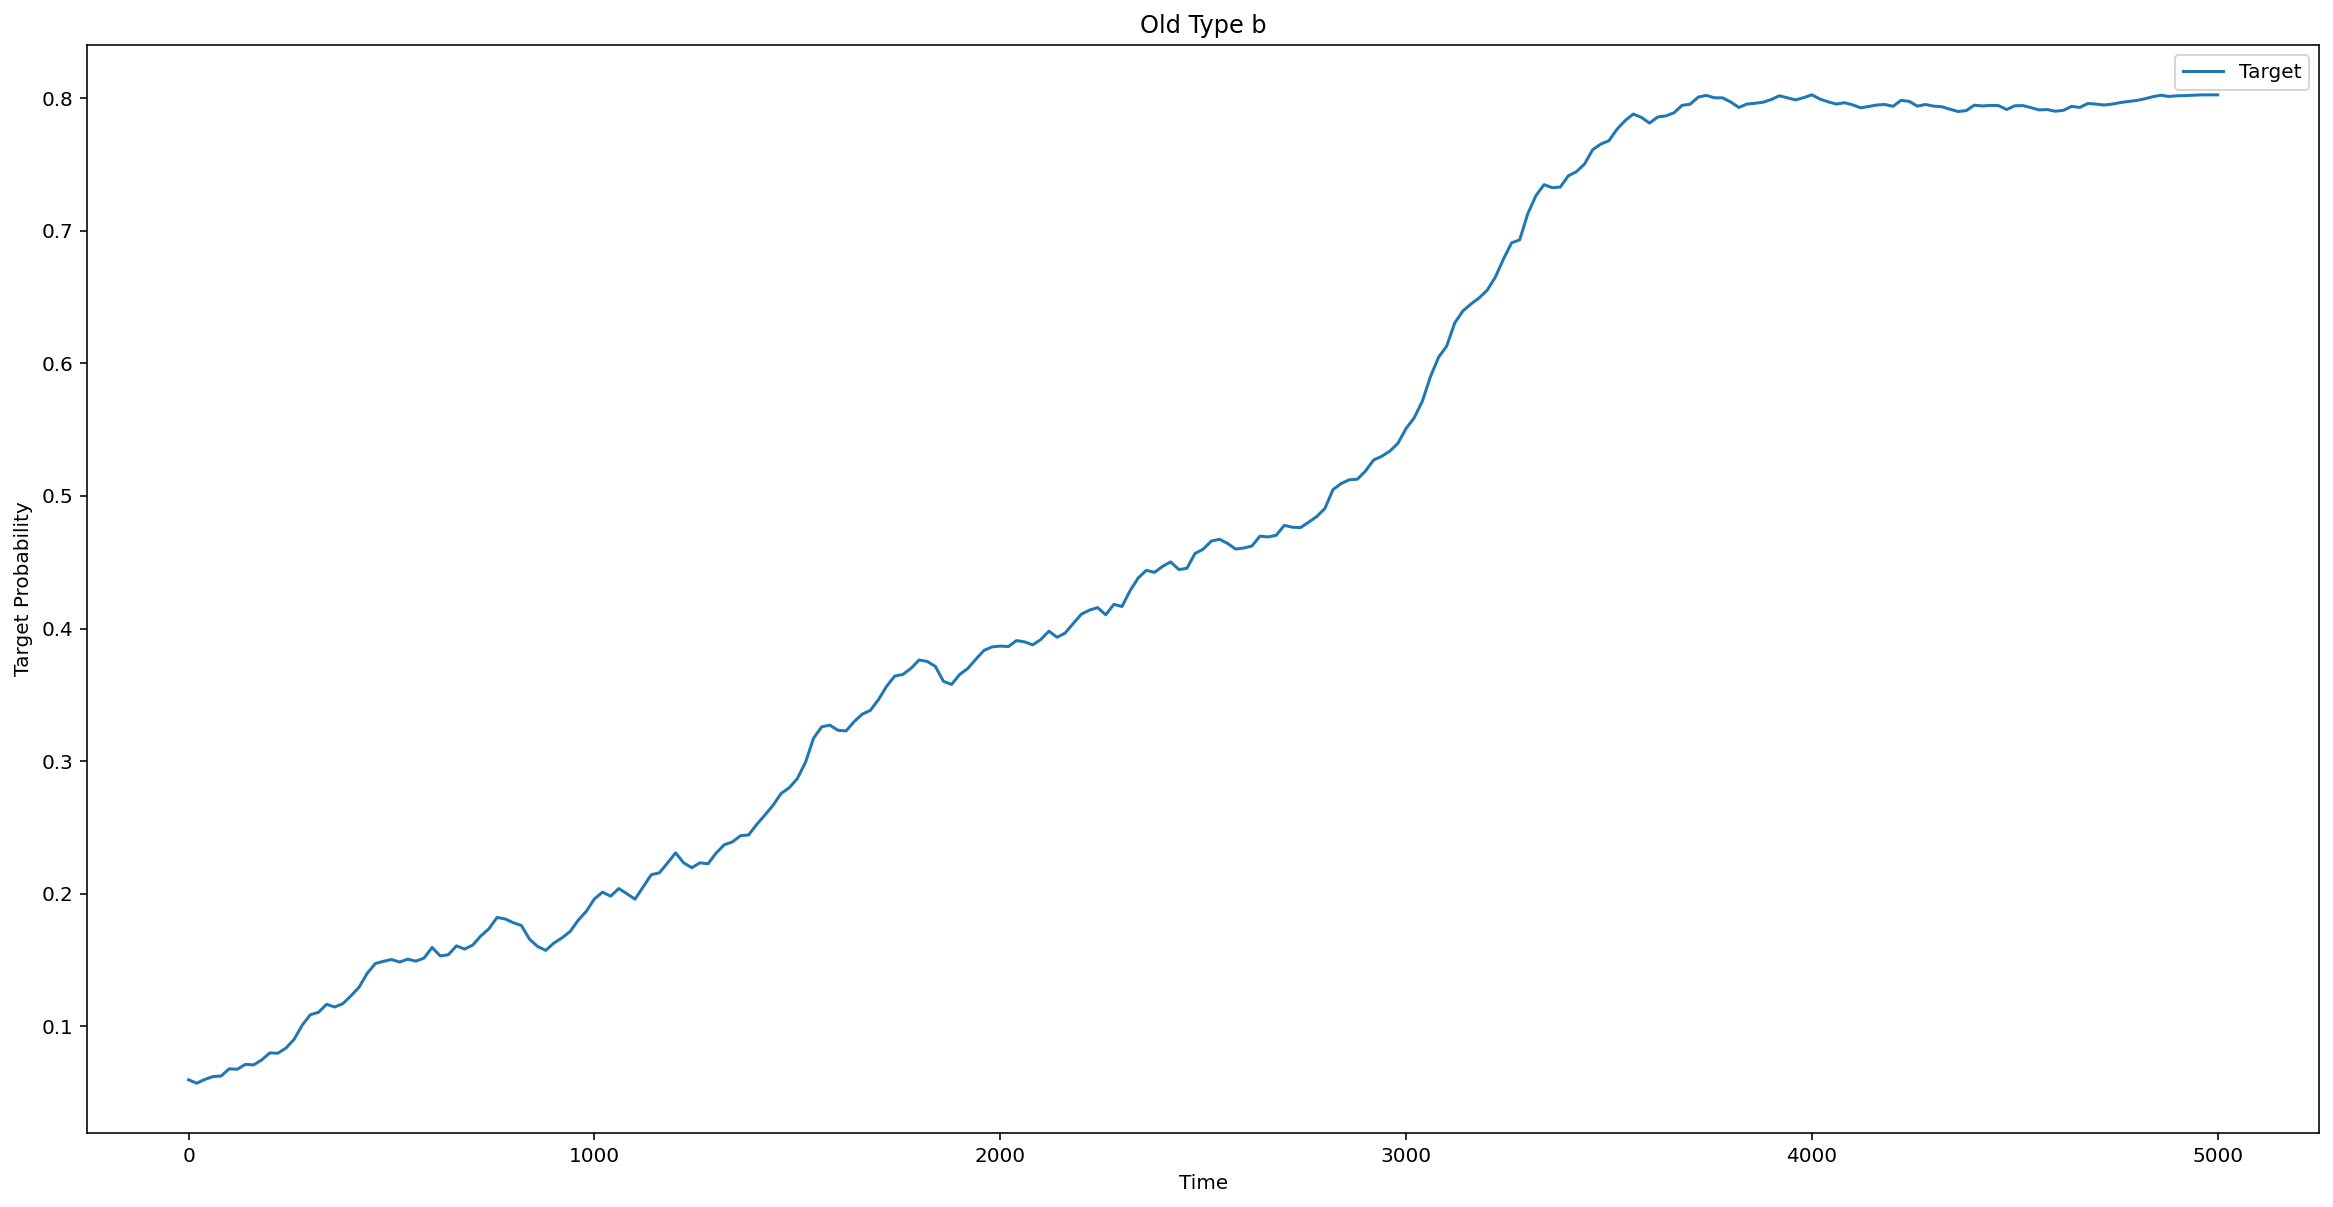

In [45]:
for t in odt4[TYPE].unique():
    odt4[odt4[TYPE] == t].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
    pp.title('Old Type ' + t)
    pp.ylabel('Target Probability')
    pp.xlabel('Time')
    pp.rcParams['figure.figsize'] = (20.0, 10.0)
    pp.show()

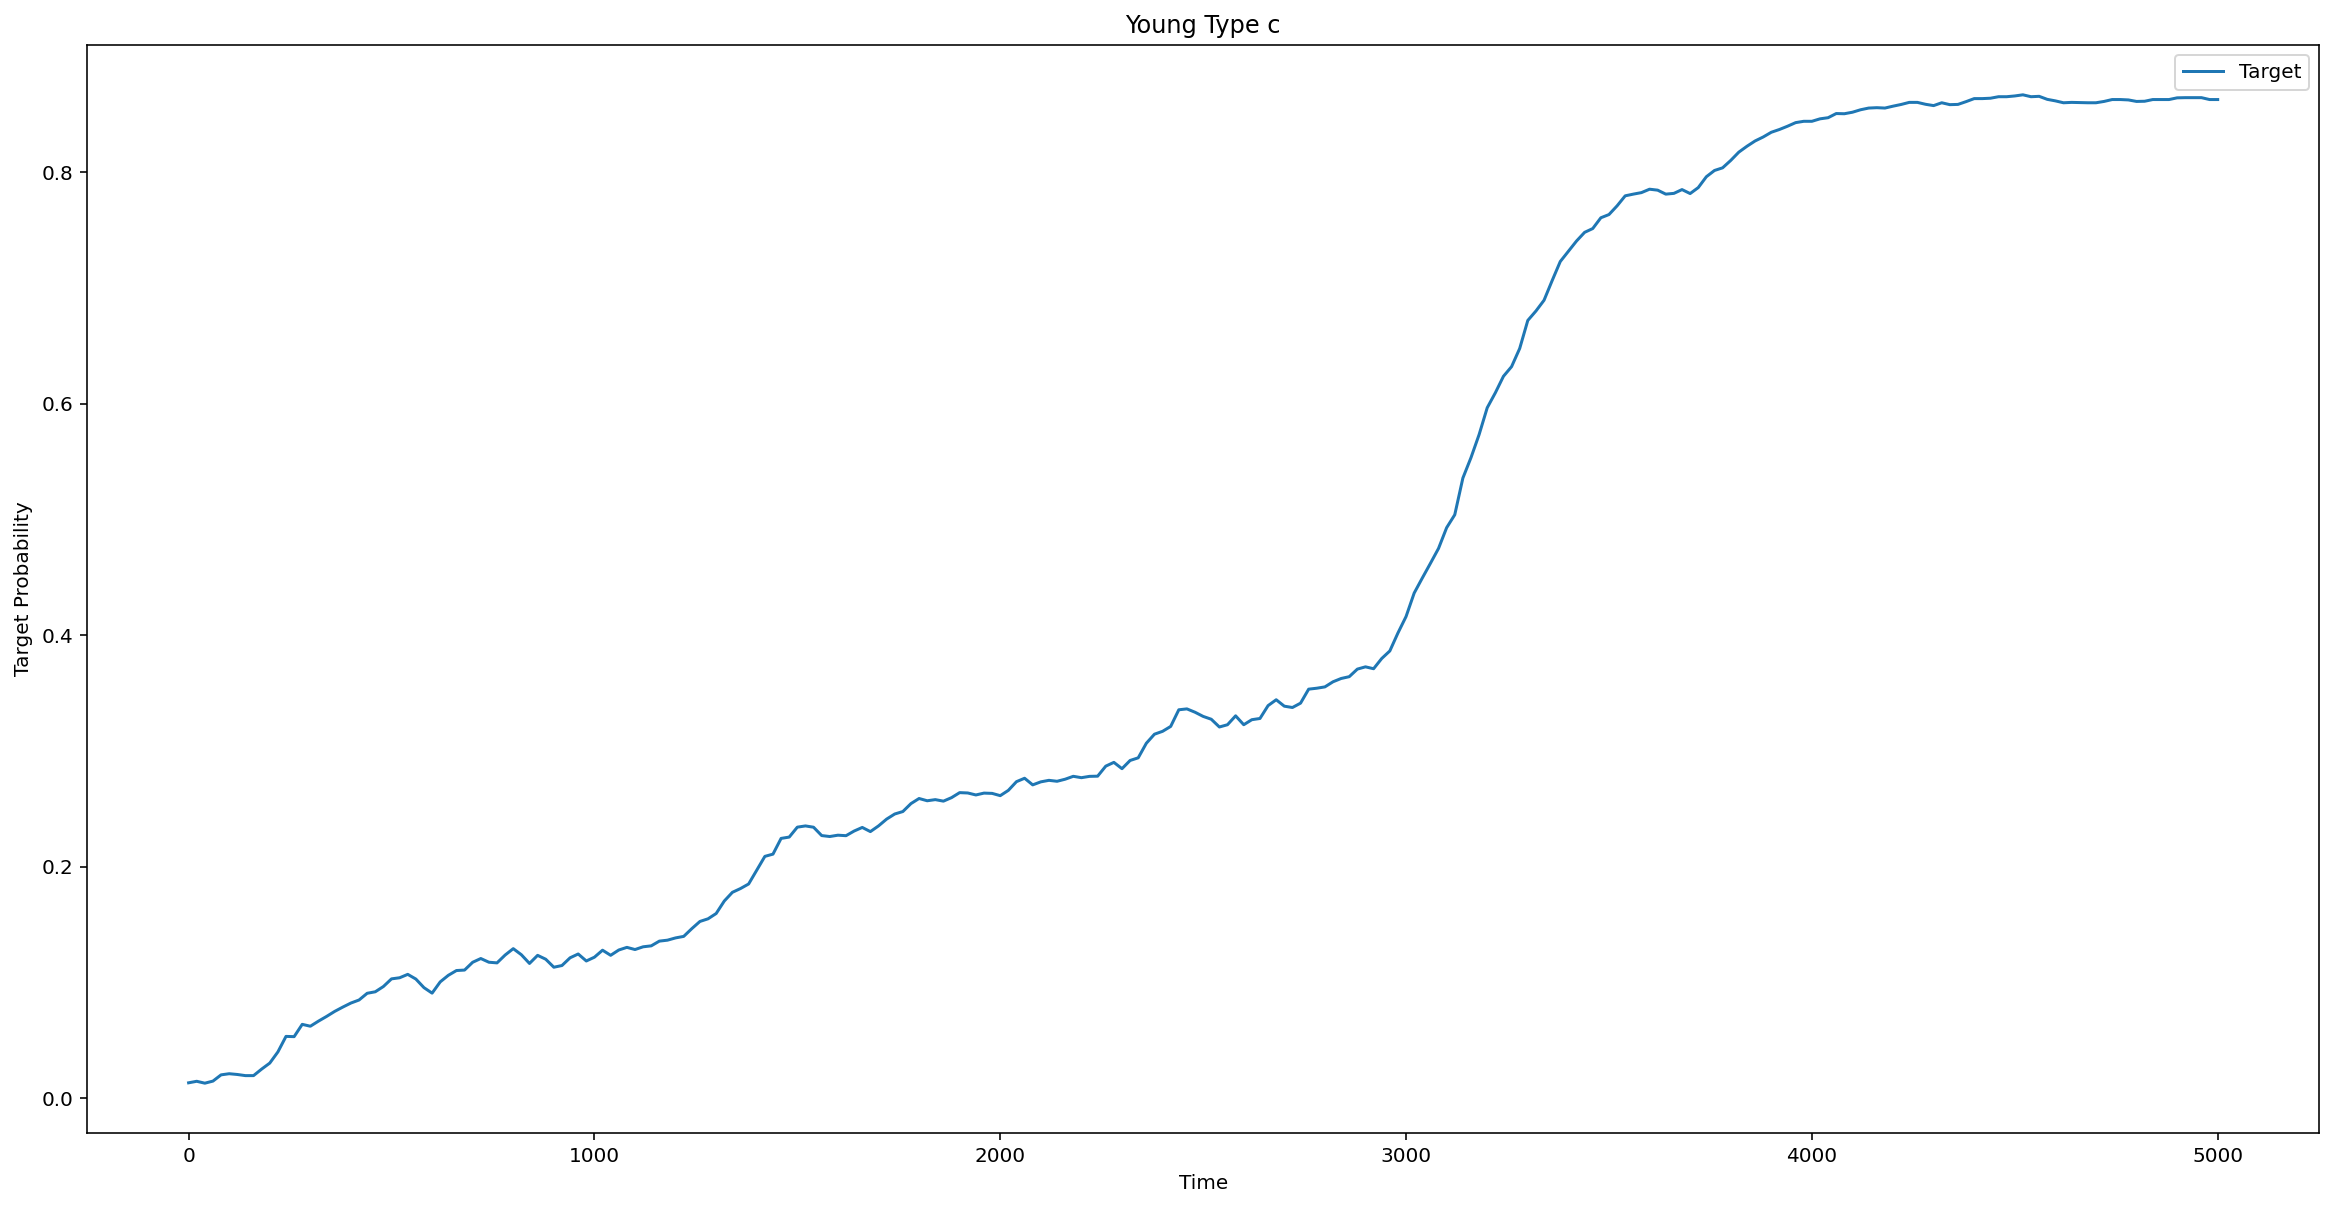

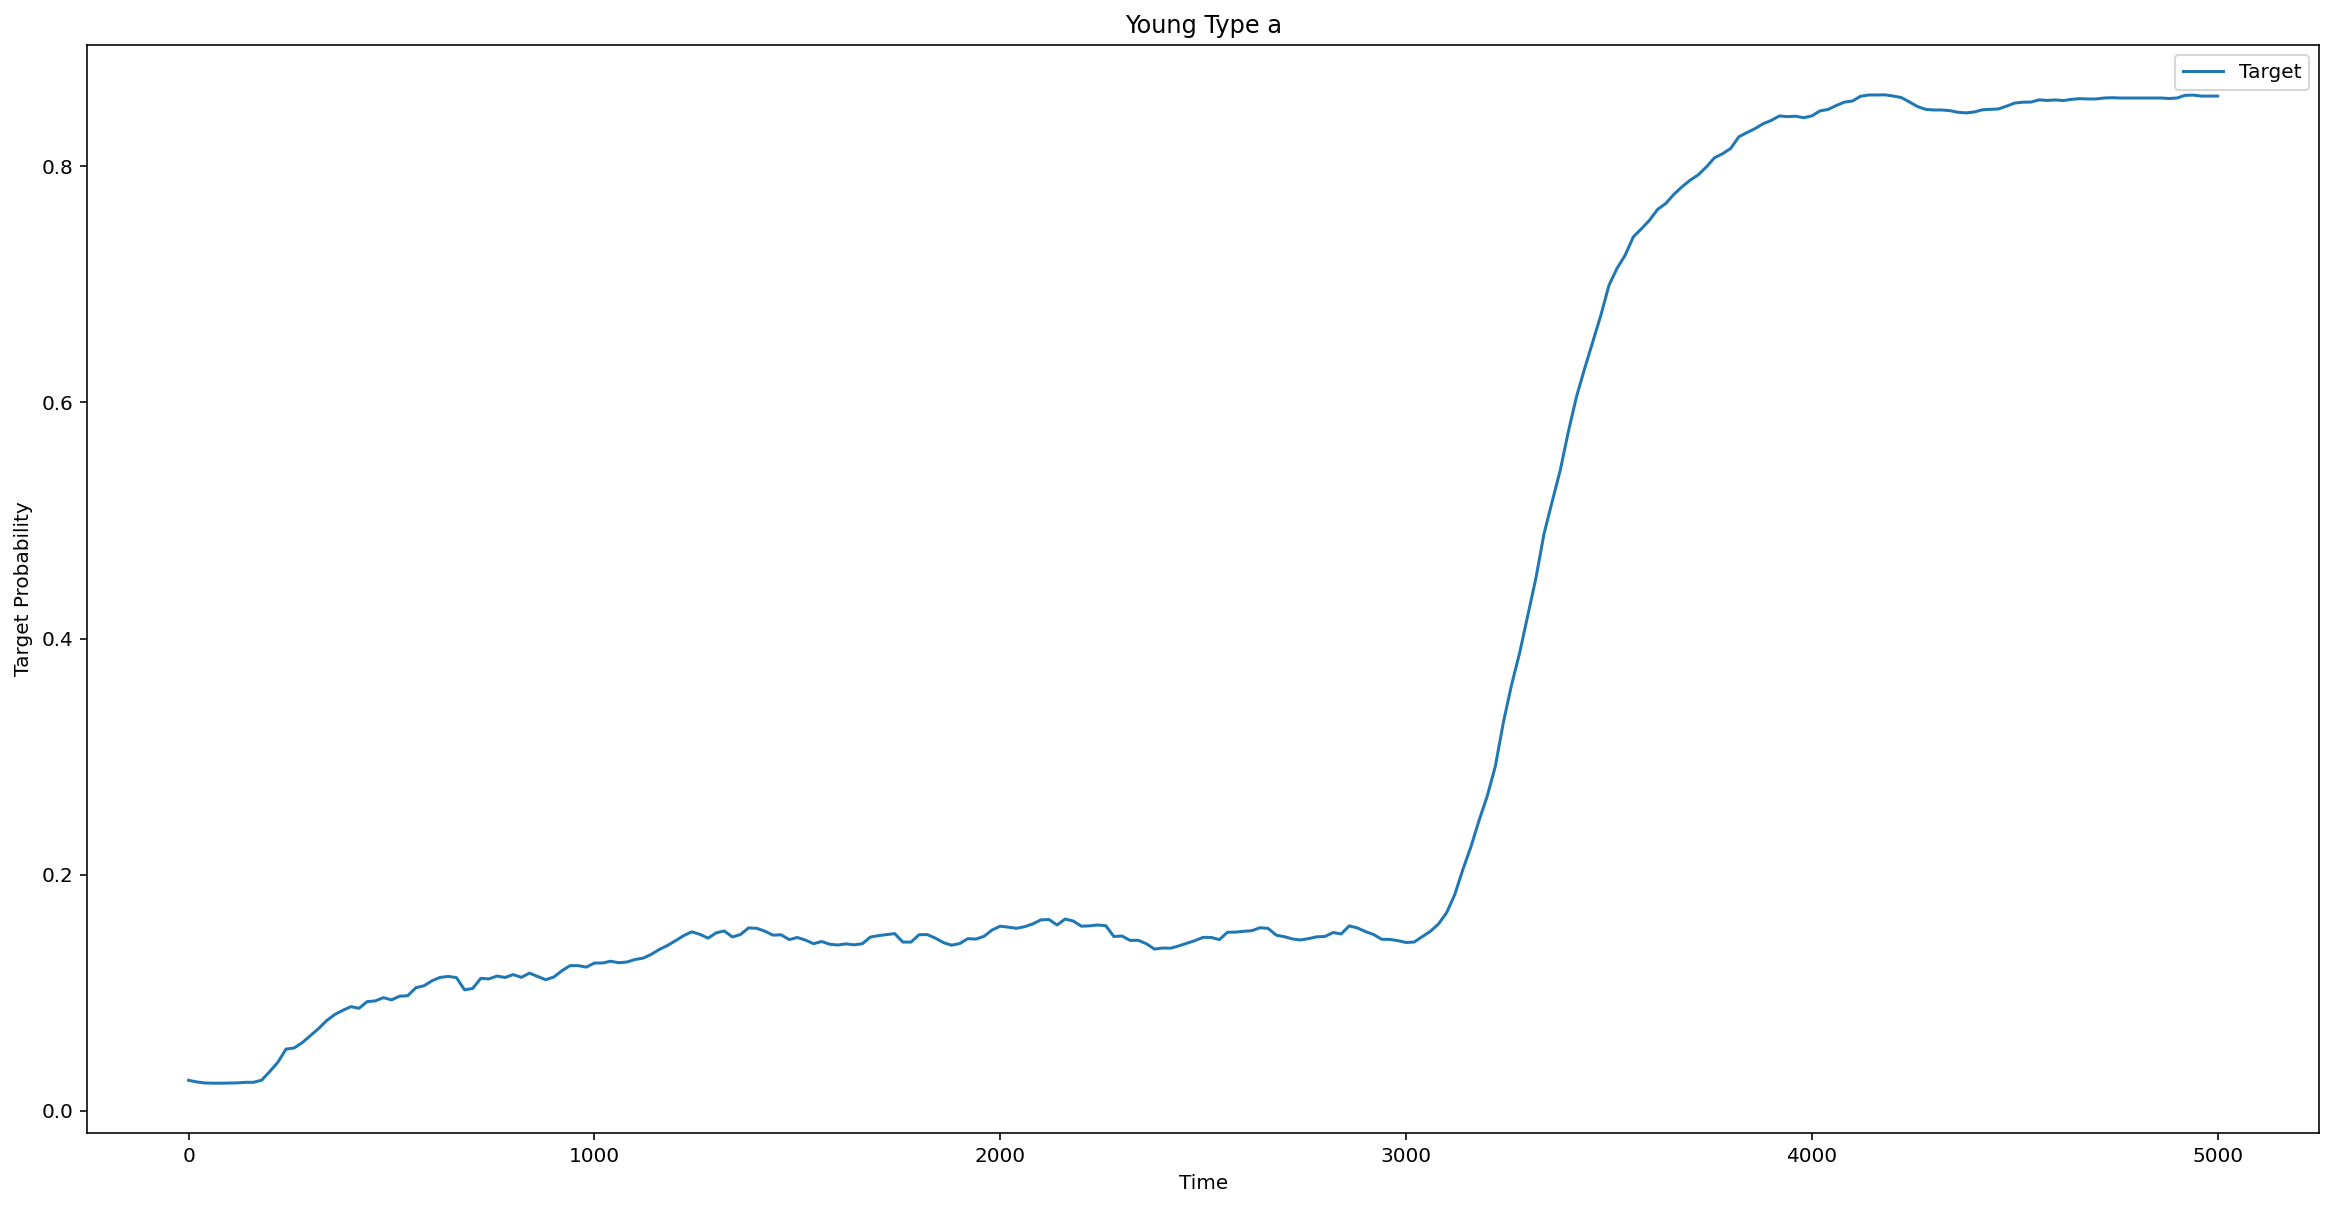

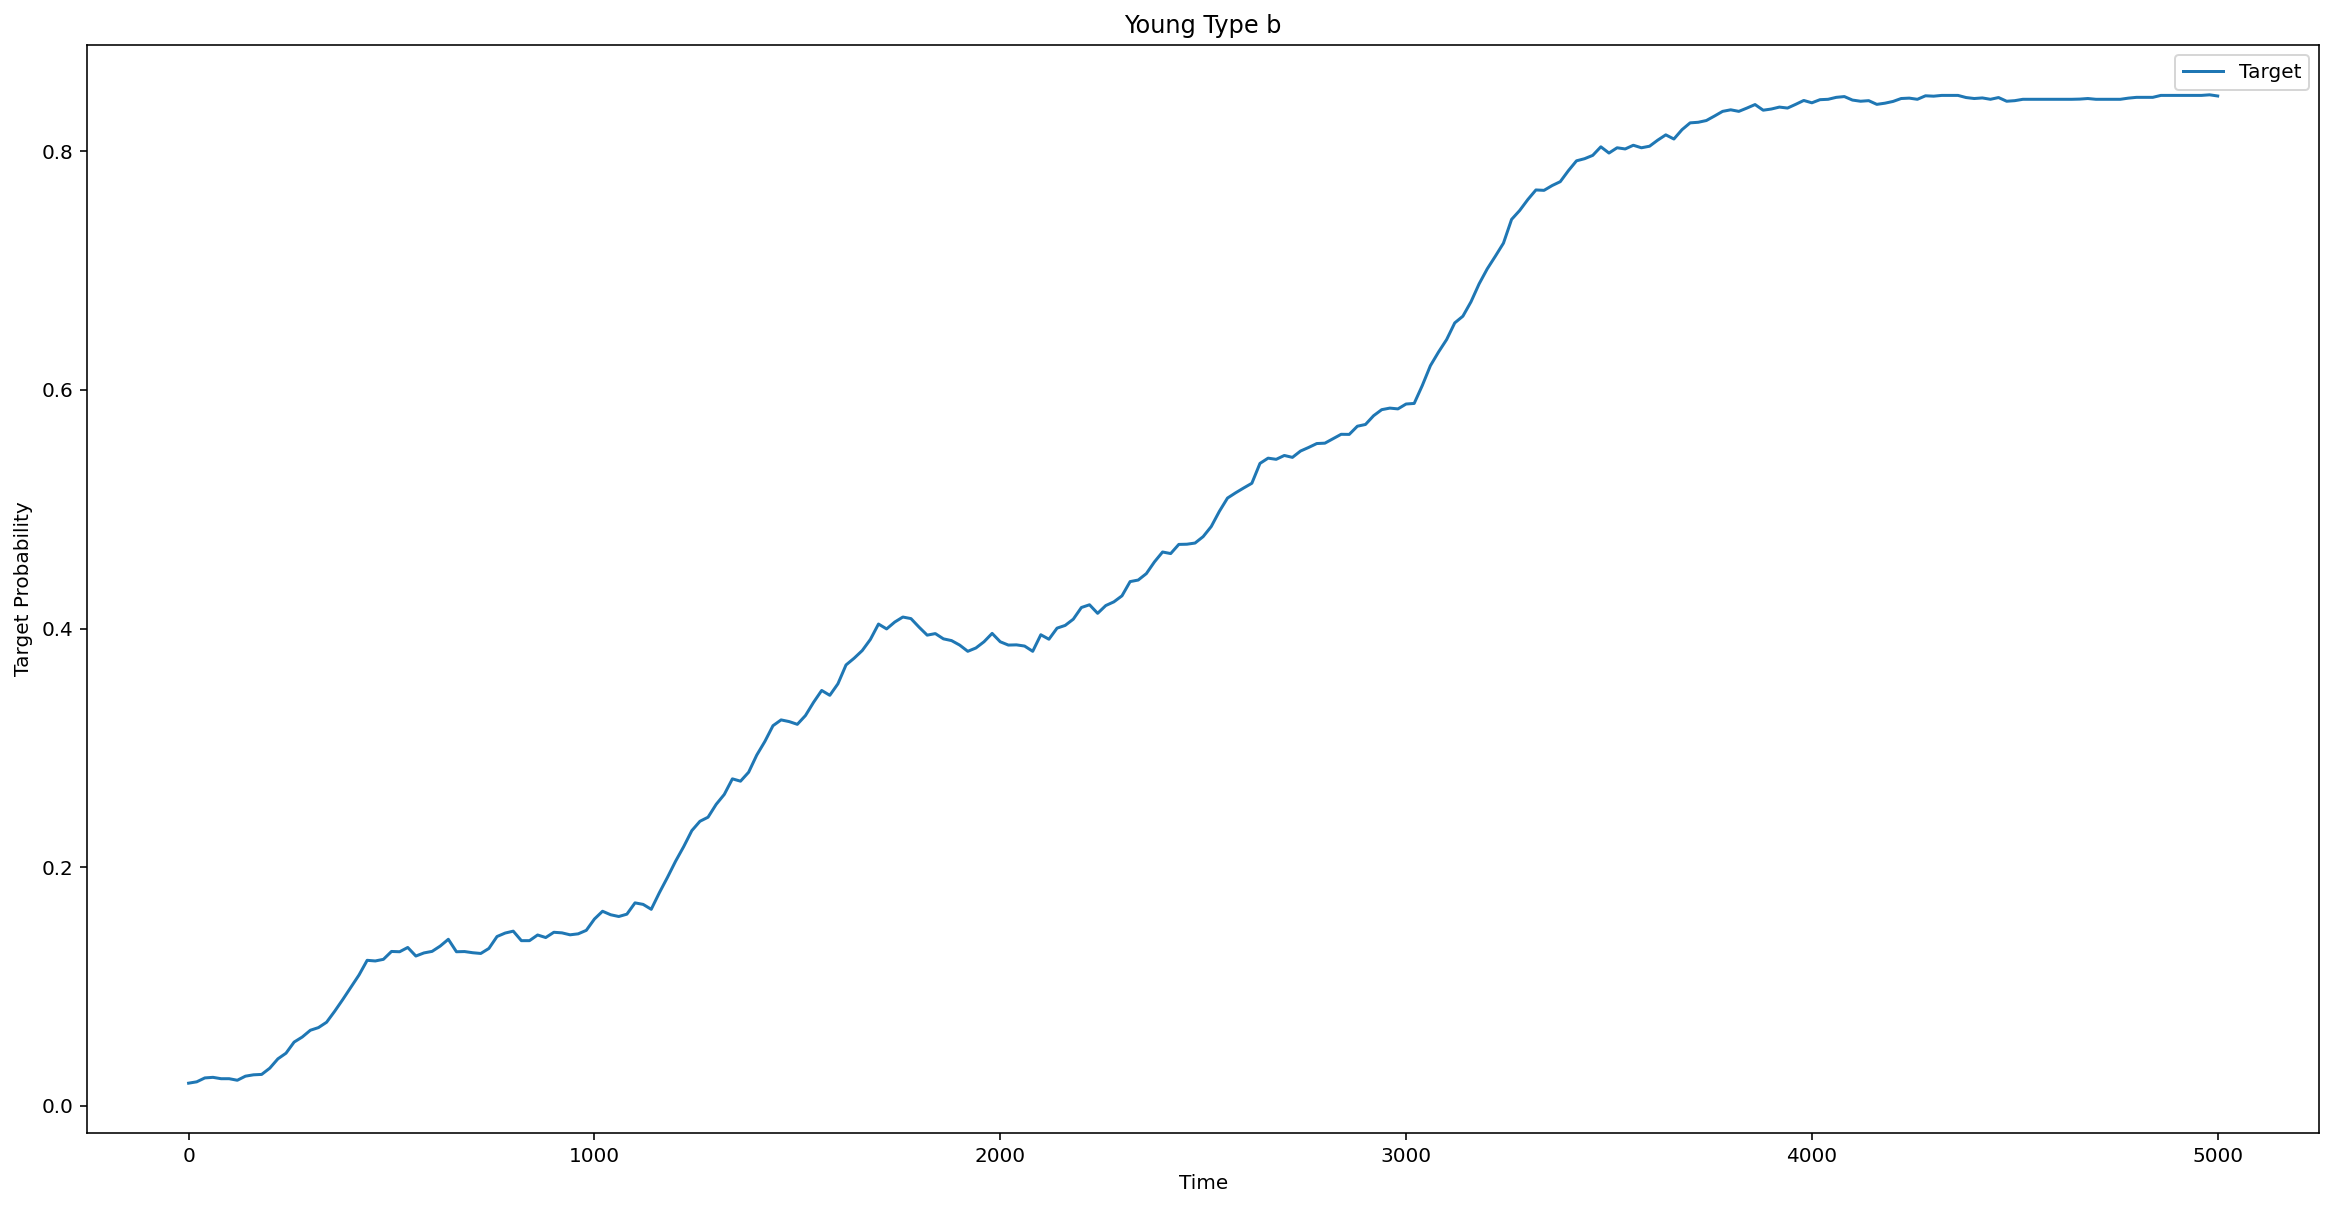

In [46]:
for t in ydt4[TYPE].unique():
    ydt4[ydt4[TYPE] == t].pivot_table(index=[TIME], values=[TARGET], aggfunc=np.average).plot()
    pp.title('Young Type ' + t)
    pp.ylabel('Target Probability')
    pp.xlabel('Time')
    pp.rcParams['figure.figsize'] = (20.0, 10.0)

In [47]:
odt4, ydt4

(         Participant  Trial type  Time Competitor DigitsCorrect Filler1  \
 2769             201      4    c     0        0.0             y     0.0   
 2770             201      4    c    20        0.0             y     0.0   
 2771             201      4    c    40        0.0             y     0.0   
 2772             201      4    c    60        0.0             y     0.0   
 2773             201      4    c    80        0.0             y     0.0   
 ...              ...    ...  ...   ...        ...           ...     ...   
 2701867          241     83    b  4920        0.0             y     0.0   
 2701868          241     83    b  4940        0.0             y     0.0   
 2701869          241     83    b  4960        0.0             y     0.0   
 2701870          241     83    b  4980        0.0             y     0.0   
 2701871          241     83    b  5000        0.0             y     0.0   
 
         Filler2 Response  TOUCH_FIXED Target  load  
 2769        0.0   Target       

now saves the new data

In [48]:
F_OLD_DATA_PADDED = F_OLD_DATA.split('.csv')[0] + '_padded_1_8.csv'
F_YOUNG_DATA_PADDED = F_YOUNG_DATA.split('.csv')[0] + '_padded_1_8.csv'
odt4.reset_index().to_csv(F_OLD_DATA_PADDED, index=False)
ydt4.reset_index().to_csv(F_YOUNG_DATA_PADDED, index=False)

In [49]:
##odt5 = odt4.sort_values([PART, TRIAL, TIME])
##odt5


# more request
## new file
each part average of each type and load


In [64]:
oda = odt4.pivot_table(index=[TIME, PART, TYPE, LOAD],
                      values=[TARGET, COMP, FILL1, FILL2],
                      aggfunc=np.average)

yda = ydt4.pivot_table(index=[TIME, PART, TYPE, LOAD],
                      values=[TARGET, COMP, FILL1, FILL2],
                      aggfunc=np.average)


oda, yda

(                            Competitor   Filler1   Filler2    Target
 Time Participant type load                                          
 0    201         a    1           0.00  0.157895  0.105263  0.268421
                       4           0.10  0.100000  0.000000  0.050000
                  b    1           0.10  0.240000  0.090000  0.130000
                       4           0.05  0.100000  0.000000  0.140000
                  c    1           0.10  0.300000  0.000000  0.070000
 ...                                ...       ...       ...       ...
 5000 241         a    4           0.00  0.000000  0.055556  0.935000
                  b    1           0.00  0.000000  0.000000  1.000000
                       4           0.00  0.000000  0.000000  0.800000
                  c    1           0.00  0.000000  0.000000  1.000000
                       4           0.00  0.000000  0.000000  0.800000
 
 [54216 rows x 4 columns],
                             Competitor  Filler1  Filler2  Ta

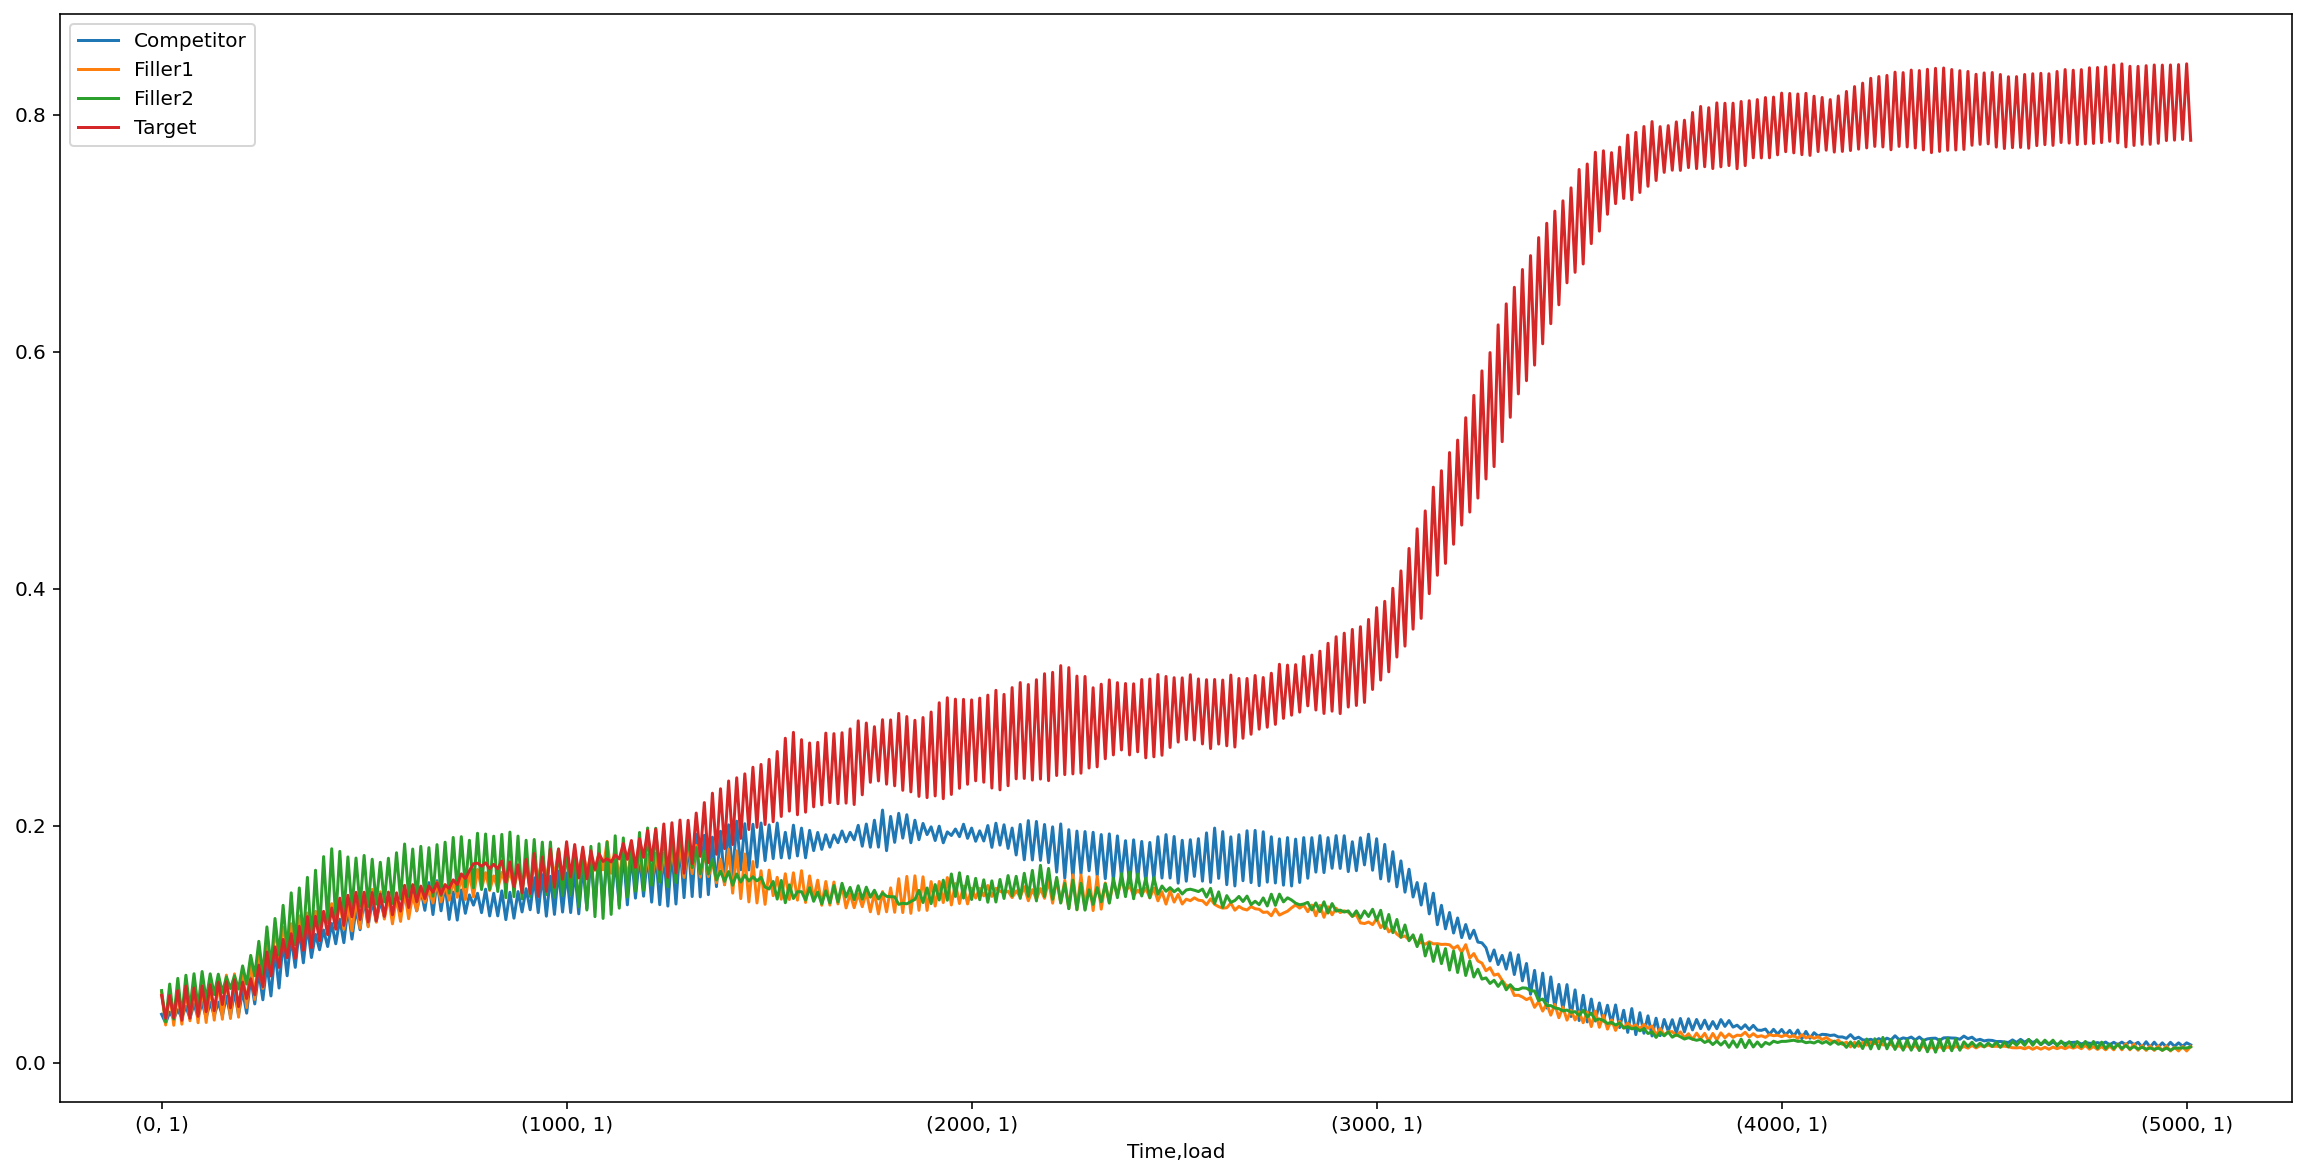

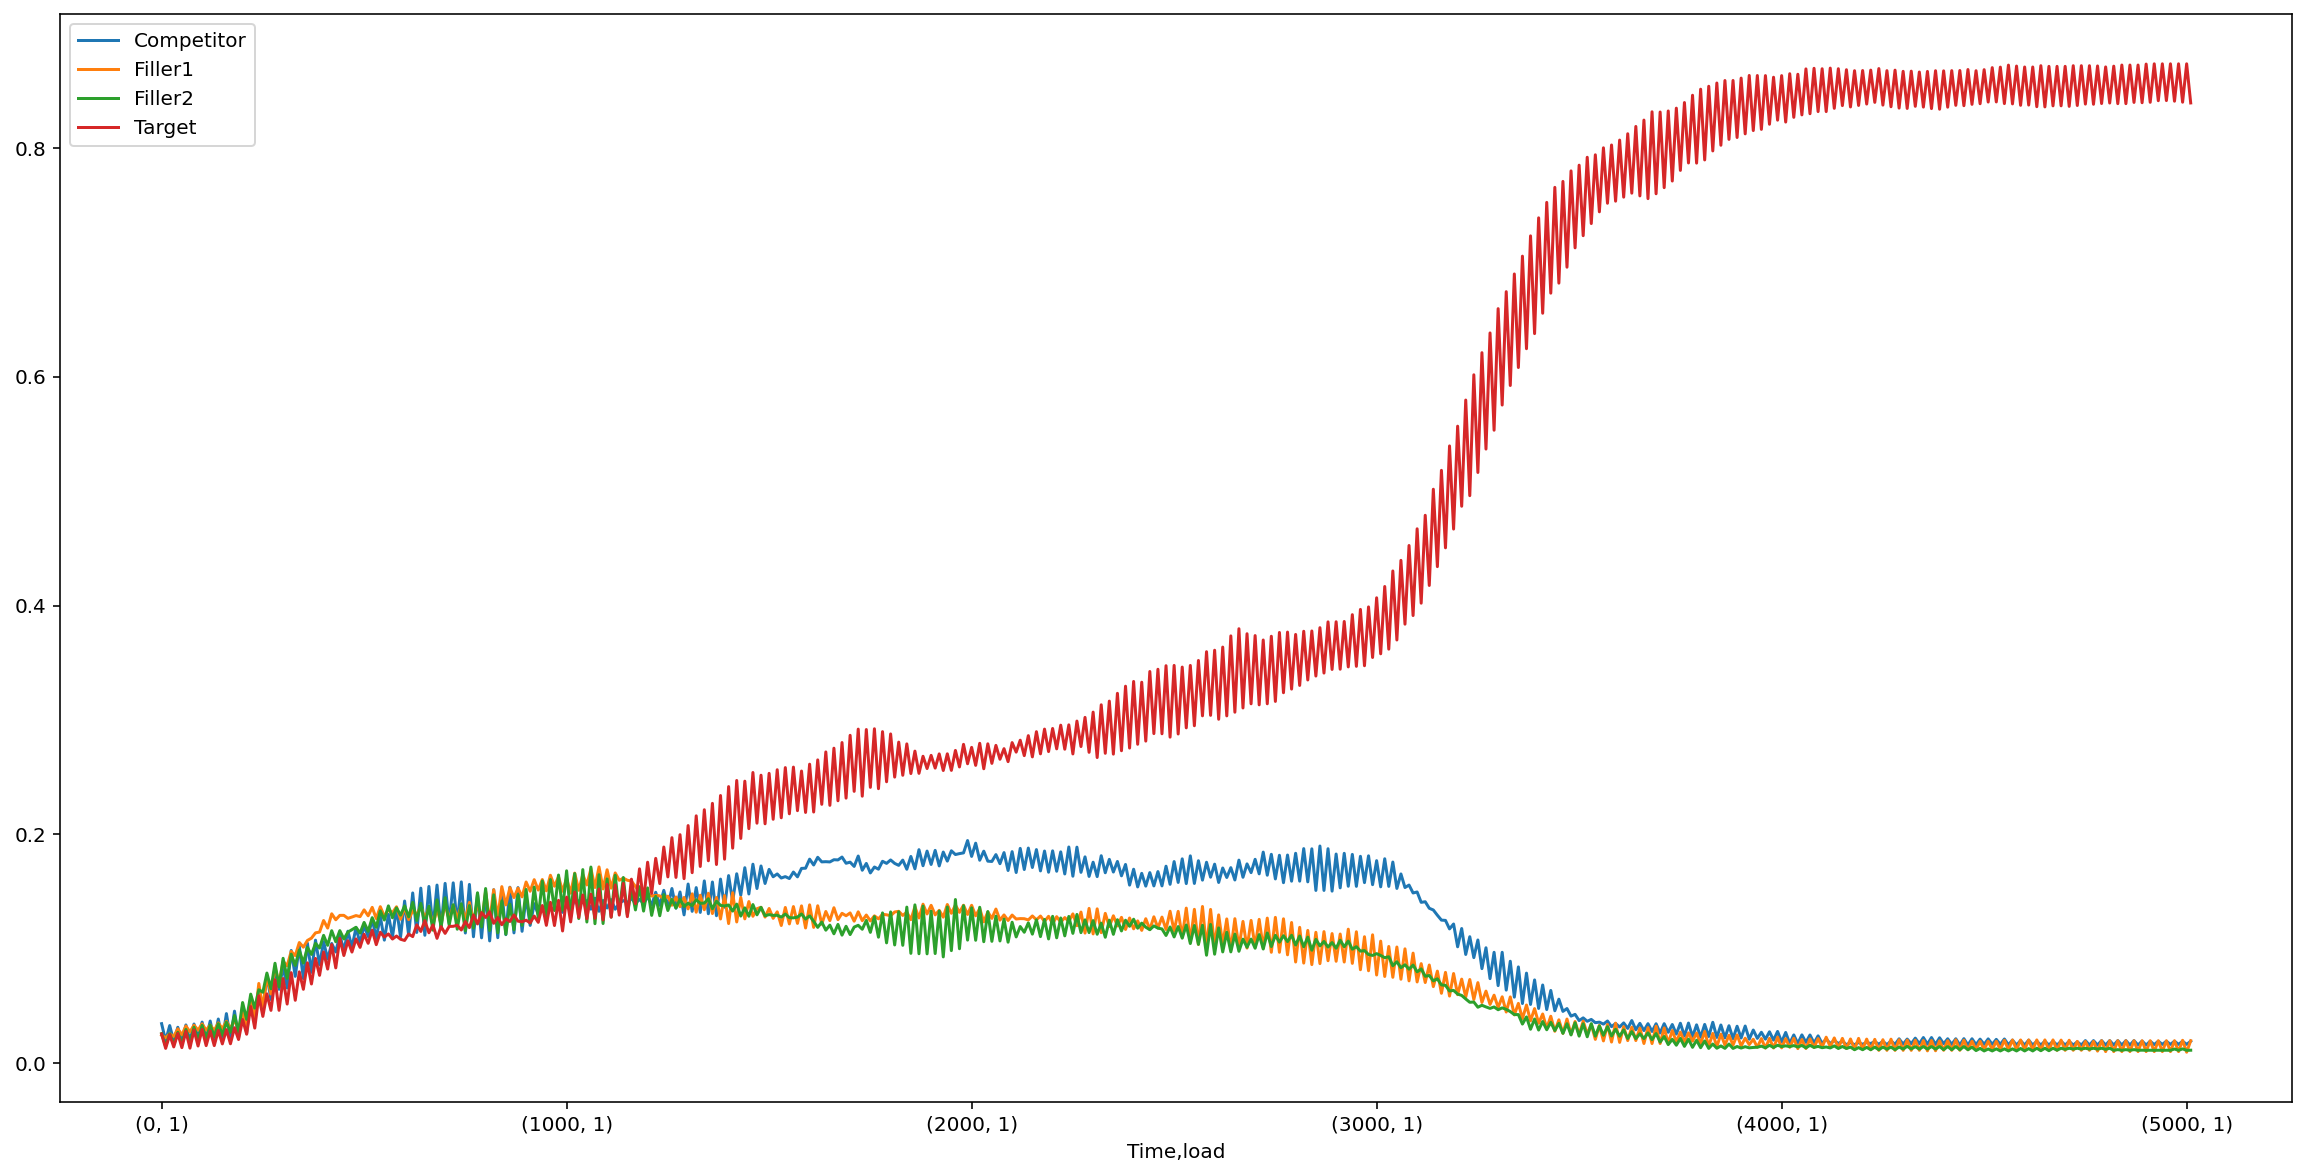

In [67]:
oda.reset_index().pivot_table(index=[TIME, LOAD], values=[TARGET, COMP, FILL1, FILL2]).plot()
pp.show()
yda.reset_index().pivot_table(index=[TIME, LOAD], values=[TARGET, COMP, FILL1, FILL2]).plot()
pp.show()

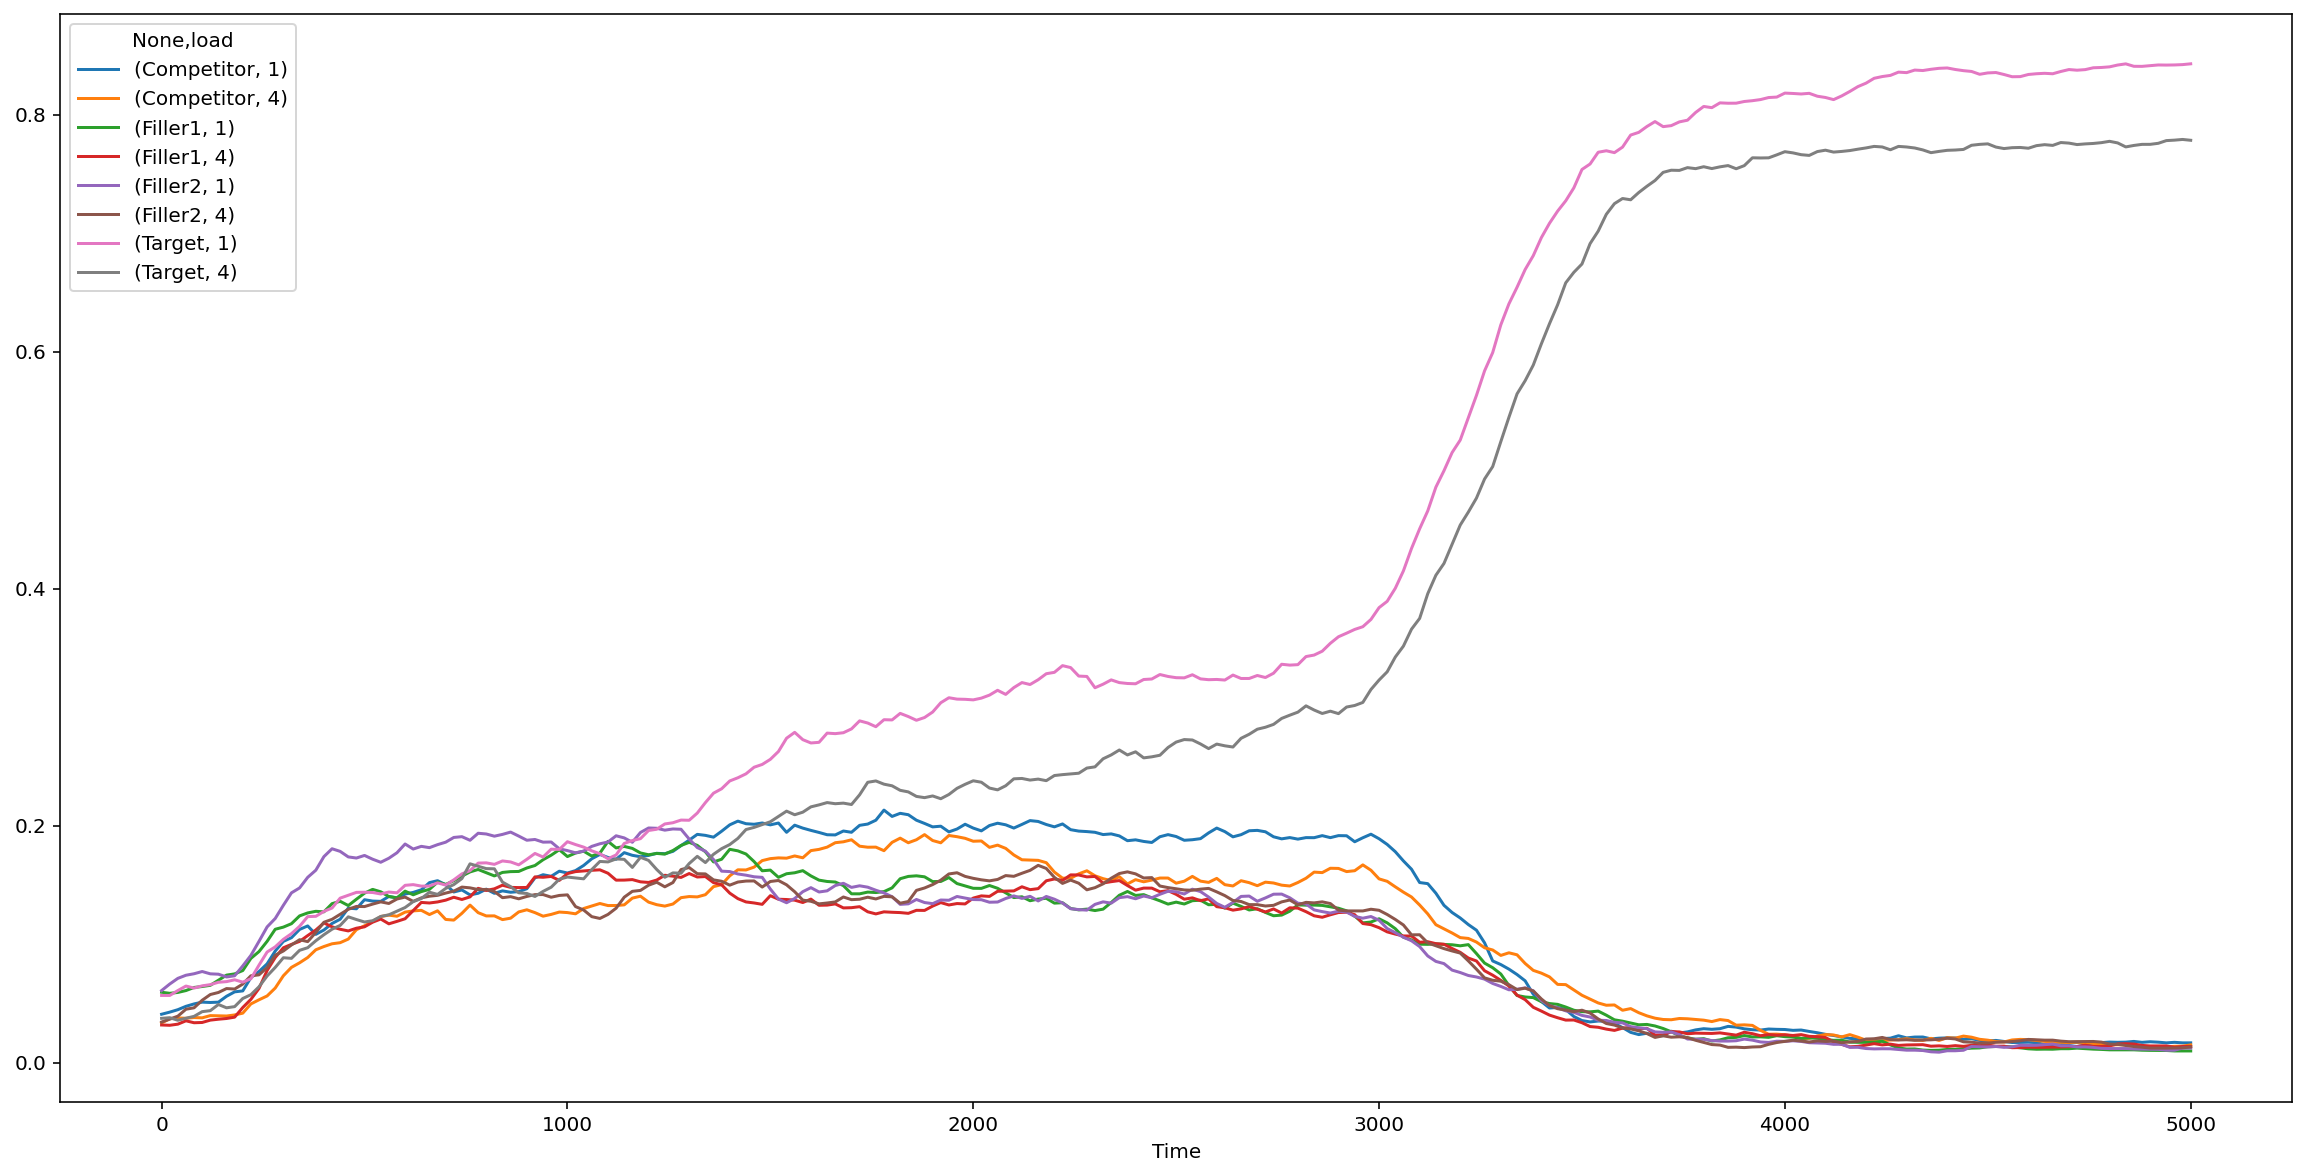

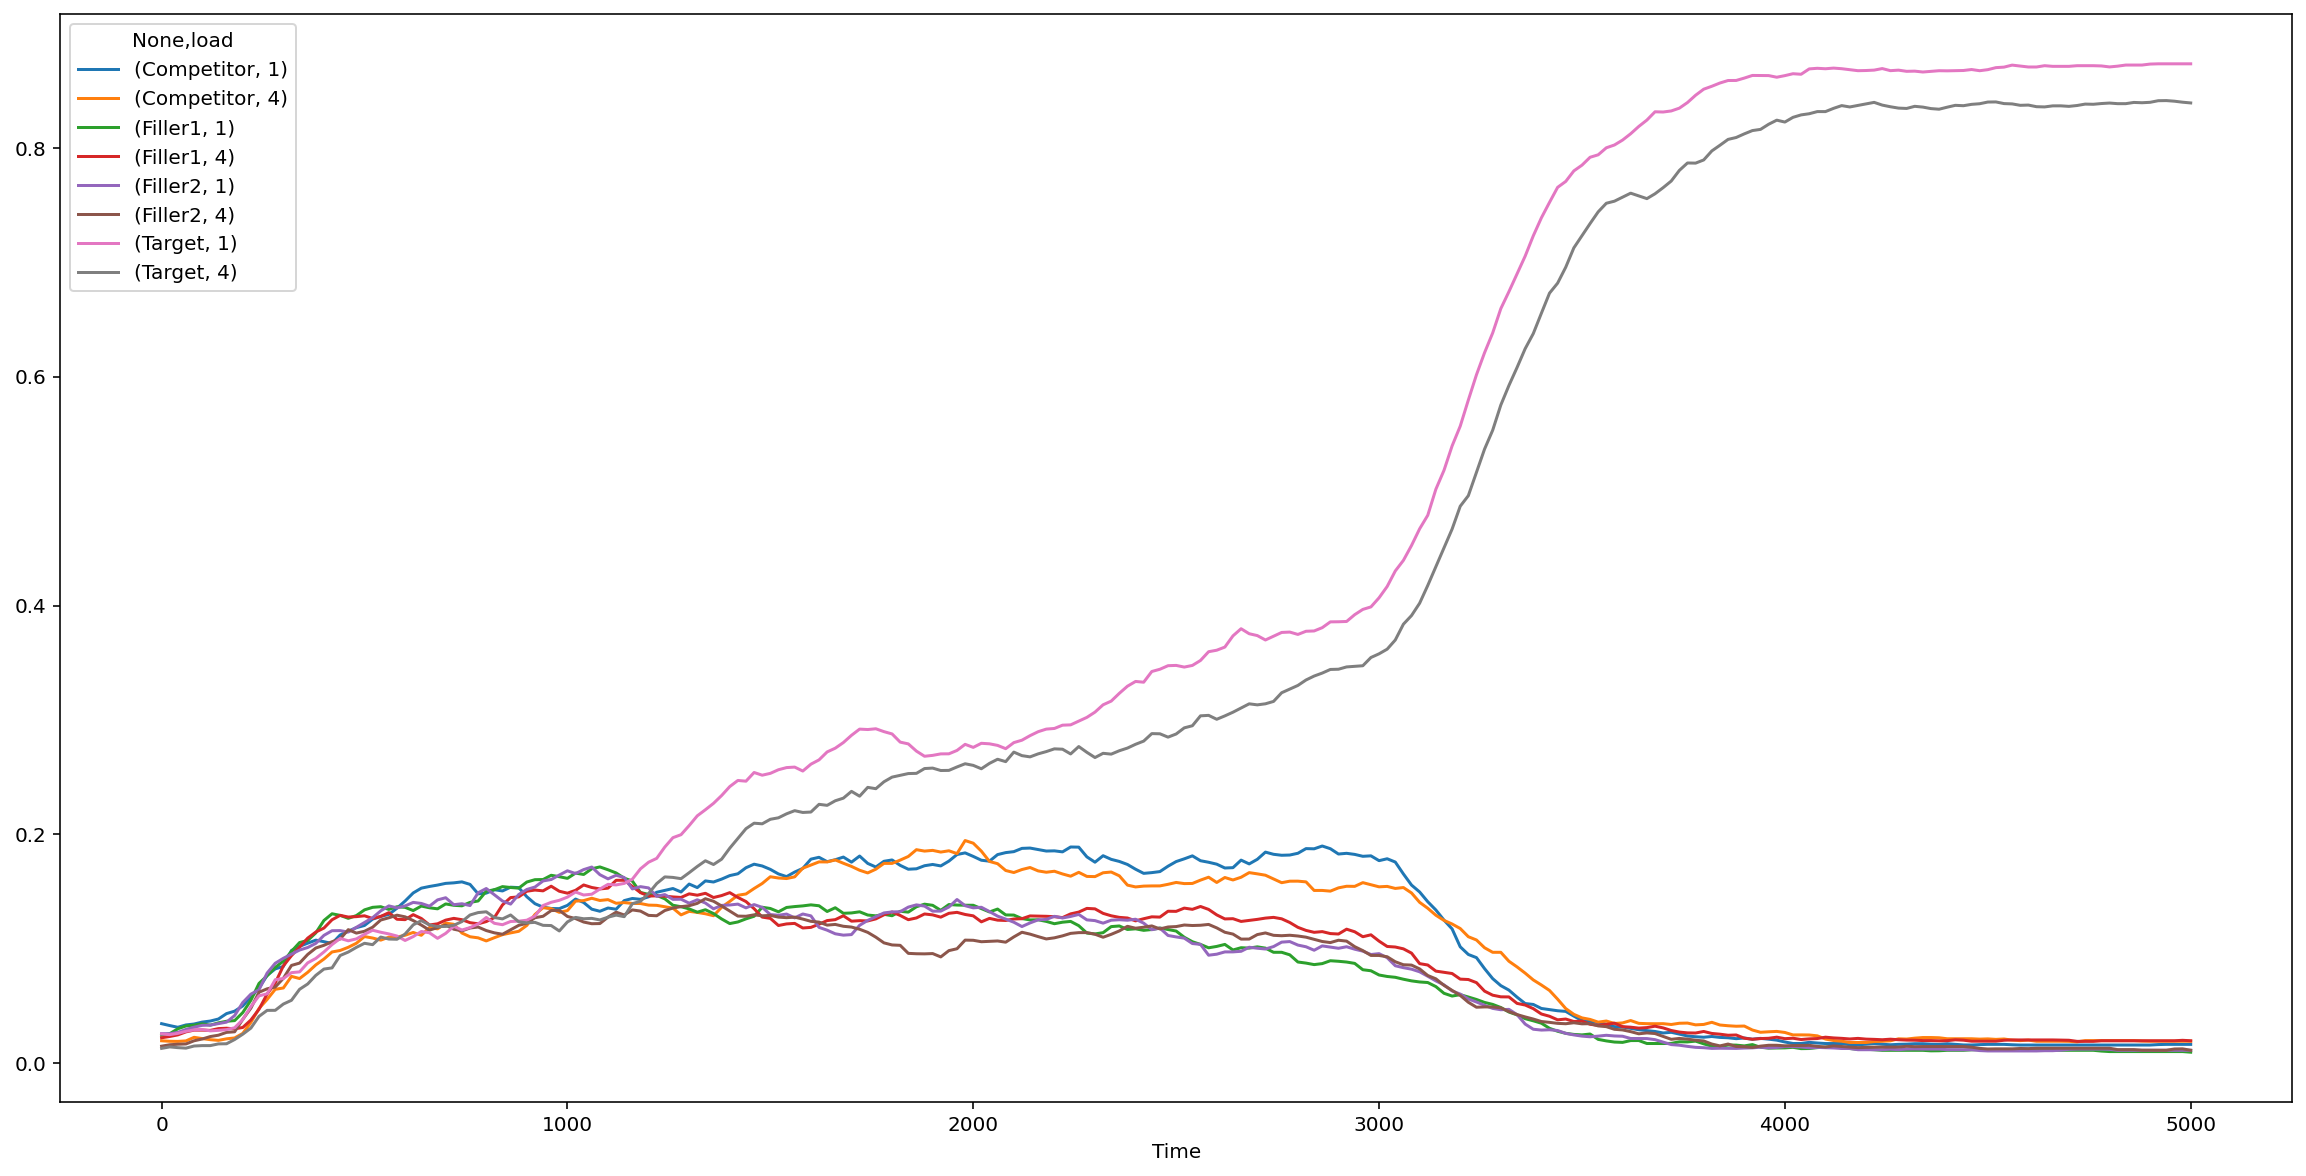

In [68]:
oda.reset_index().pivot_table(index=[TIME], columns=[LOAD], values=[TARGET, COMP, FILL1, FILL2]).plot()
pp.show()
yda.reset_index().pivot_table(index=[TIME], columns=[LOAD], values=[TARGET, COMP, FILL1, FILL2]).plot()
pp.show()